# Fault Classification Analysis

This notebook implements and evaluates multiple machine learning models for multi-class fault classification on the Tennessee Eastman Process dataset.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from datetime import datetime
from typing import Union, List, Dict

# Data preparation imports
import pyreadr
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Machine Learning
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score
)
import xgboost as xgb
import lightgbm as lgb
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tabulate import tabulate

In [2]:
def save_plot(plot_name: str,
              suffix: str = "",
              plot_path: str = "Classification") -> None:
    """Save current matplotlib figure with organized folder structure."""
    timestamp: str = ""

    # Determine subfolder based on plot type
    if "confusion_matrix" in plot_name.lower():
        subfolder = "confusion_matrices"
    elif "per_class" in plot_name.lower(
    ) or "class_difficulty" in plot_name.lower():
        subfolder = "per_class_analysis"
    elif "feature_importance" in plot_name.lower():
        subfolder = "feature_analysis"
    elif "cross_validation" in plot_name.lower() or "cv" in plot_name.lower():
        subfolder = "cross_validation"
    elif "model_comparison" in plot_name.lower(
    ) or "ranking" in plot_name.lower() or "specialization" in plot_name.lower(
    ):
        subfolder = "model_comparison"
    elif "neural" in plot_name.lower() and ("history" in plot_name.lower() or
                                            "training" in plot_name.lower()):
        subfolder = "training_history"
    elif "detection_delay" in plot_name.lower():
        subfolder = "detection_analysis"
    else:
        subfolder = "general"

    base_dir: str = os.path.join(OUTPUT_PATH, "data", plot_path, subfolder)
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{plot_name}_{suffix}_v{VERSION}_{timestamp}.png" if suffix else f"{plot_name}_v{VERSION}_{timestamp}.png"
    filepath: str = os.path.join(base_dir, filename)

    plt.savefig(filepath, bbox_inches="tight", dpi=300)
    print(f"Plot saved: {filepath}")


def save_dataframe(df: pd.DataFrame, name: str, suffix: str = "") -> None:
    """Save a DataFrame to CSV with organized folder structure."""
    timestamp: str = ""

    # Determine subfolder based on data type
    if "per_class" in name.lower() or "class_difficulty" in name.lower(
    ) or "class_wise" in name.lower():
        subfolder = "per_class_data"
    elif "model_results" in name.lower() or "ranking" in name.lower(
    ) or "specialization" in name.lower():
        subfolder = "model_analysis"
    elif "feature" in name.lower():
        subfolder = "feature_analysis"
    elif "detection_delay" in name.lower():
        subfolder = "detection_analysis"
    elif "detailed_metrics" in name.lower():
        subfolder = "detailed_metrics"
    else:
        subfolder = "general_data"

    base_dir: str = os.path.join(OUTPUT_PATH, "data", subfolder)
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{name}_{suffix}_v{VERSION}_{timestamp}.csv" if suffix else f"{name}_v{VERSION}_{timestamp}.csv"
    filepath: str = os.path.join(base_dir, filename)

    df.to_csv(filepath, index=True)
    print(f"Data saved: {filepath}")


def save_pickle(obj, name: str, suffix: str = "") -> None:
    """Save object as pickle file with organized folder structure."""
    timestamp: str = ""

    # Determine subfolder based on object type
    if "model" in name.lower():
        subfolder = "models"
    else:
        subfolder = "general_objects"

    base_dir: str = os.path.join(OUTPUT_PATH, "data", "Classification",
                                 subfolder)
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{name}_{suffix}_v{VERSION}_{timestamp}.pkl" if suffix else f"{name}_v{VERSION}_{timestamp}.pkl"
    filepath: str = os.path.join(base_dir, filename)

    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Model saved: {filepath}")

In [3]:
# Configuration
VERSION = "1.00"
OUTPUT_PATH = "output"

# Model names
XGBOOST = "XGBoost"
LIGHTGBM = "LightGBM"
RANDOM_FOREST = "Random Forest"
EXTRA_TREES = "Extra Trees"
GRADIENT_BOOSTING = "Gradient Boosting"
ADABOOST = "AdaBoost"
SVM = "SVM"
KNN = "K-Nearest Neighbors"
NAIVE_BAYES = "Naive Bayes"
DECISION_TREE = "Decision Tree"
LOGISTIC_REGRESSION = "Logistic Regression"
NEURAL_NET = "Neural Network"
ENSEMBLE_VOTING = "Ensemble (Voting)"

In [4]:
# Configuration
VERSION = "1.00"
OUTPUT_PATH = "output"

def save_plot(plot_name: str,
              plot_path: str = "Classification",
              suffix: str = "") -> None:
    """Save plot with proper version and folder structure."""
    timestamp: str = ""

    # Determine subfolder based on plot type
    if "confusion" in plot_name.lower() or "matrix" in plot_name.lower():
        subfolder = "confusion_matrices"
    elif "roc" in plot_name.lower() or "auc" in plot_name.lower():
        subfolder = "roc_curves"
    elif "precision_recall" in plot_name.lower() or "pr_curve" in plot_name.lower():
        subfolder = "precision_recall"
    elif "learning_curve" in plot_name.lower():
        subfolder = "learning_curves"
    elif "feature_importance" in plot_name.lower():
        subfolder = "feature_analysis"
    elif "cross_validation" in plot_name.lower() or "cv" in plot_name.lower():
        subfolder = "cross_validation"
    elif "model_comparison" in plot_name.lower() or "ranking" in plot_name.lower() or "specialization" in plot_name.lower():
        subfolder = "model_comparison"
    elif "neural" in plot_name.lower() and ("history" in plot_name.lower() or "training" in plot_name.lower()):
        subfolder = "training_history"
    elif "detection_delay" in plot_name.lower():
        subfolder = "detection_analysis"
    elif "per_class" in plot_name.lower() or "class_" in plot_name.lower() or "arl" in plot_name.lower():
        subfolder = "per_class_analysis"
    else:
        subfolder = "general"

    # Create proper version-based path structure
    base_dir: str = os.path.join(OUTPUT_PATH, VERSION, "data", plot_path, "plots", subfolder)
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{plot_name}_{suffix}_v{VERSION}_{timestamp}.png" if suffix else f"{plot_name}_v{VERSION}_{timestamp}.png"
    filepath: str = os.path.join(base_dir, filename)

    plt.savefig(filepath, bbox_inches="tight", dpi=300)
    print(f"Plot saved: {filepath}")


def save_dataframe(df: pd.DataFrame, name: str, suffix: str = "") -> None:
    """Save a DataFrame to CSV with organized version folder structure."""
    timestamp: str = ""

    # Determine subfolder based on data type and suffix
    if "per_class" in name.lower() or "class_difficulty" in name.lower() or "class_wise" in name.lower() or suffix == "per_class_analysis":
        subfolder = "per_class_analysis"
    elif "model_results" in name.lower() or "ranking" in name.lower() or "specialization" in name.lower():
        subfolder = "model_analysis"
    elif "feature" in name.lower():
        subfolder = "feature_analysis"
    elif "detection_delay" in name.lower():
        subfolder = "detection_analysis"
    elif "detailed_metrics" in name.lower() or "arl" in name.lower() or "enhanced" in name.lower():
        subfolder = "per_class_analysis"
    else:
        subfolder = "general_data"

    # Create proper version-based path structure
    base_dir: str = os.path.join(OUTPUT_PATH, VERSION, "data", "Classification", subfolder)
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{name}_{suffix}_v{VERSION}_{timestamp}.csv" if suffix else f"{name}_v{VERSION}_{timestamp}.csv"
    filepath: str = os.path.join(base_dir, filename)

    df.to_csv(filepath, index=True)
    print(f"Data saved: {filepath}")


def save_pickle(obj, name: str, suffix: str = "") -> None:
    """Save object as pickle file with organized version folder structure."""
    timestamp: str = ""

    # Determine subfolder based on object type
    if "model" in name.lower():
        subfolder = "models"
    else:
        subfolder = "general_objects"

    # Create proper version-based path structure
    base_dir: str = os.path.join(OUTPUT_PATH, VERSION, "data", "Classification", subfolder)
    os.makedirs(base_dir, exist_ok=True)

    filename: str = f"{name}_{suffix}_v{VERSION}_{timestamp}.pkl" if suffix else f"{name}_v{VERSION}_{timestamp}.pkl"
    filepath: str = os.path.join(base_dir, filename)

    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Object saved: {filepath}")

print("✅ Configuration and save functions updated with proper version folder structure!")
print(f"📁 Output structure: {OUTPUT_PATH}/{VERSION}/data/Classification/")
print(f"🔢 Version: {VERSION}")

✅ Configuration and save functions updated with proper version folder structure!
📁 Output structure: output/1.00/data/Classification/
🔢 Version: 1.00


## Load Prepared Data

In [5]:
# ====================================================================
# STANDALONE CLASSIFICATION DATA PREPARATION
# ====================================================================

print("=== STANDALONE CLASSIFICATION DATA PREPARATION ===")
print("Preparing data specifically for multi-class fault classification...")

# Configuration for classification
TARGET_VARIABLE_COLUMN_NAME = "faultNumber"
SIMULATION_RUN_COLUMN_NAME = "simulationRun"
COLUMNS_TO_REMOVE = ["simulationRun", "sample"]
SKIPED_FAULTS = []

# Load raw data
print("Loading raw data files...")
fault_free_training_dict = pyreadr.read_r("data/TEP_FaultFree_Training.RData")
fault_free_testing_dict = pyreadr.read_r("data/TEP_FaultFree_Testing.RData")
faulty_training_dict = pyreadr.read_r("data/TEP_Faulty_Training.RData")
faulty_testing_dict = pyreadr.read_r("data/TEP_Faulty_Testing.RData")

# Extract DataFrames
DF_FF_TRAINING_RAW = fault_free_training_dict["fault_free_training"]
DF_FF_TEST_RAW = fault_free_testing_dict["fault_free_testing"]
DF_F_TRAINING_RAW = faulty_training_dict["faulty_training"]
DF_F_TEST_RAW = faulty_testing_dict["faulty_testing"]

print(f"✓ Raw data loaded: Train Fault-free {DF_FF_TRAINING_RAW.shape}, Train Faulty {DF_F_TRAINING_RAW.shape}")

# Skip specified faults (if any)
DF_F_TRAIN_SKIPPED = DF_F_TRAINING_RAW[~DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].isin(SKIPED_FAULTS)].reset_index(drop=True)
DF_F_TEST_SKIPPED = DF_F_TEST_RAW[~DF_F_TEST_RAW[TARGET_VARIABLE_COLUMN_NAME].isin(SKIPED_FAULTS)].reset_index(drop=True)

# Reduce data for development (keeping balanced samples)
DF_FF_TRAINING_REDUCED = DF_FF_TRAINING_RAW[(DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] > 0) & 
                                           (DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] < 5)].drop(columns=COLUMNS_TO_REMOVE, axis=1)
DF_F_TRAINING_REDUCED = DF_F_TRAIN_SKIPPED[(DF_F_TRAIN_SKIPPED[SIMULATION_RUN_COLUMN_NAME] > 0) & 
                                          (DF_F_TRAIN_SKIPPED[SIMULATION_RUN_COLUMN_NAME] < 2)].drop(columns=COLUMNS_TO_REMOVE, axis=1)

# For testing, use reduced datasets
DF_FF_TEST_REDUCED = DF_FF_TEST_RAW[(DF_FF_TEST_RAW[SIMULATION_RUN_COLUMN_NAME] > 0) & 
                                   (DF_FF_TEST_RAW[SIMULATION_RUN_COLUMN_NAME] < 5)].drop(columns=COLUMNS_TO_REMOVE, axis=1)
DF_F_TEST_REDUCED = DF_F_TEST_SKIPPED[(DF_F_TEST_SKIPPED[SIMULATION_RUN_COLUMN_NAME] > 0) & 
                                     (DF_F_TEST_SKIPPED[SIMULATION_RUN_COLUMN_NAME] < 3)].drop(columns=COLUMNS_TO_REMOVE, axis=1)

print(f"✓ Data reduced: Train sets - fault free: {DF_FF_TRAINING_REDUCED.shape}, faulty: {DF_F_TRAINING_REDUCED.shape}")

# Concatenate training and testing datasets for classification
DF_TRAINING_REDUCED_CONCATED = pd.concat([DF_FF_TRAINING_REDUCED, DF_F_TRAINING_REDUCED], ignore_index=True)
DF_TEST_REDUCED_CONCATED = pd.concat([DF_FF_TEST_REDUCED, DF_F_TEST_REDUCED], ignore_index=True)

print(f"✓ Data concatenated: Train {DF_TRAINING_REDUCED_CONCATED.shape}, Test {DF_TEST_REDUCED_CONCATED.shape}")

# Prepare features and labels for classification
X_TRAIN = DF_TRAINING_REDUCED_CONCATED.drop(columns=[TARGET_VARIABLE_COLUMN_NAME], axis=1).to_numpy()
Y_TRAIN_DF = DF_TRAINING_REDUCED_CONCATED[TARGET_VARIABLE_COLUMN_NAME]

X_TEST_REDUCED = DF_TEST_REDUCED_CONCATED.drop(columns=[TARGET_VARIABLE_COLUMN_NAME], axis=1).to_numpy()
Y_TEST_REDUCED_DF = DF_TEST_REDUCED_CONCATED[TARGET_VARIABLE_COLUMN_NAME]

# Standardize features
scaler = StandardScaler()
X_TRAIN = scaler.fit_transform(X_TRAIN)
X_TEST_REDUCED = scaler.transform(X_TEST_REDUCED)

# Encode labels for classification
label_encoder = LabelEncoder()
Y_TRAIN = label_encoder.fit_transform(Y_TRAIN_DF)
Y_TEST_REDUCED = label_encoder.transform(Y_TEST_REDUCED_DF)

# One-hot encode for neural networks
onehot_encoder = OneHotEncoder(sparse_output=False)
Y_reshaped = Y_TRAIN.reshape(-1, 1)
Y_ENC_TRAIN = onehot_encoder.fit_transform(Y_reshaped)

Y_test_reshaped = Y_TEST_REDUCED.reshape(-1, 1)
Y_ENC_TEST_REDUCED = onehot_encoder.transform(Y_test_reshaped)

print(f"✓ Features standardized and labels encoded")
print(f"✓ Training features shape: {X_TRAIN.shape}")
print(f"✓ Training labels shape: {Y_TRAIN.shape}")
print(f"✓ Test features shape: {X_TEST_REDUCED.shape}")
print(f"✓ Test labels shape: {Y_TEST_REDUCED.shape}")
print(f"✓ Unique classes: {sorted(np.unique(Y_TRAIN))}")
print(f"✓ Unique fault numbers: {sorted(label_encoder.classes_)}")
print("=== CLASSIFICATION DATA PREPARATION COMPLETE ===\n")

=== STANDALONE CLASSIFICATION DATA PREPARATION ===
Preparing data specifically for multi-class fault classification...
Loading raw data files...
✓ Raw data loaded: Train Fault-free (250000, 55), Train Faulty (5000000, 55)
✓ Raw data loaded: Train Fault-free (250000, 55), Train Faulty (5000000, 55)
✓ Data reduced: Train sets - fault free: (2000, 53), faulty: (10000, 53)
✓ Data concatenated: Train (12000, 53), Test (42240, 53)
✓ Features standardized and labels encoded
✓ Training features shape: (12000, 52)
✓ Training labels shape: (12000,)
✓ Test features shape: (42240, 52)
✓ Test labels shape: (42240,)
✓ Unique classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]
✓ Unique fault numbers: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(

In [6]:
DF_TRAINING_REDUCED_CONCATED.head()

,faultNumber,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [7]:
Y_TEST_REDUCED

array([ 0,  0,  0, ..., 20, 20, 20])

## Evaluation Functions

In [8]:
def compute_first_detection_delay(
        y_true: Union[List[int], np.ndarray],
        y_pred: Union[List[int], np.ndarray]) -> pd.DataFrame:
    """Compute first detection delay for each fault type."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    fault_labels = sorted(np.unique(y_true[y_true > 0]))
    results = []

    for fault in fault_labels:
        fault_mask = y_true == fault
        fault_indices = np.where(fault_mask)[0]
        
        if len(fault_indices) == 0:
            delay = None
        else:
            start_index = fault_indices[0]
            detection_indices = np.where(
                (y_pred == fault) & (np.arange(len(y_pred)) >= start_index)
            )[0]
            delay = (detection_indices[0] - start_index if len(detection_indices) > 0 else None)

        results.append({
            "Fault": fault,
            "First Detection Delay": delay if (delay is not None and delay >= 0) else np.nan,
        })

    return pd.DataFrame(results)

In [9]:
def compute_classification_metrics_per_class(
        y_true: Union[list[int], np.ndarray],
        y_pred: Union[list[int], np.ndarray]) -> pd.DataFrame:
    """Compute detailed classification metrics per class."""
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]
    metrics: list[dict] = []

    for i in range(n_classes):
        tp: int = cm[i, i]
        fn: int = cm[i, :].sum() - tp
        fp: int = cm[:, i].sum() - tp
        tn: int = cm.sum() - (tp + fp + fn)

        acc: float = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
        prec: float = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec: float = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        tnr: float = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        fpr: float = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        npv: float = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        bal_acc: float = (rec + tnr) / 2
        f1: float = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

        metrics.append({
            "Class": i,
            "Accuracy": acc,
            "Precision": prec,
            "Recall / TPR": rec,
            "F1-Score": f1,
            "FPR": fpr,
            "NPV (Negative Predictive Value)": npv,
            "Balanced Accuracy": bal_acc,
        })

    return pd.DataFrame(metrics).set_index("Class")

def macro_false_alarm_rate(y_true: Union[list[int], np.ndarray],
                          y_pred: Union[list[int], np.ndarray]) -> float:
    """Compute macro-averaged false alarm rate."""
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]
    fpr_list: list[float] = []

    for i in range(n_classes):
        fp: int = cm[:, i].sum() - cm[i, i]
        tn: int = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fpr: float = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fpr_list.append(fpr)

    return float(np.mean(fpr_list))

## Model Training and Evaluation

In [10]:
# Initialize results storage
models_results_list: list[dict] = []
classification_results_per_model: dict[str, pd.DataFrame] = {}
delay_tables_dict: dict[str, pd.DataFrame] = {}
trained_models: dict[str, object] = {}

def evaluate_model(model_name: str, y_true, y_pred, model_object=None) -> None:
    """Comprehensive model evaluation."""
    # Basic metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    far = macro_false_alarm_rate(y_true, y_pred)
    
    models_results_list.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "False Alarm Rate": far,
    })
    
    # Detailed per-class metrics
    classification_results_per_model[model_name] = compute_classification_metrics_per_class(y_true, y_pred)
    
    # Detection delay
    delay_tables_dict[model_name] = compute_first_detection_delay(y_true, y_pred)
    
    # Save model
    if model_object is not None:
        trained_models[model_name] = model_object
        save_pickle(model_object, f"model_{model_name.lower().replace(' ', '_')}")
    
    print(f"Evaluated {model_name}: Accuracy={acc:.3f}, F1={f1:.3f}")

## Random Forest

In [11]:
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_TRAIN, Y_TRAIN_DF)
y_pred_rf = rf.predict(X_TEST_REDUCED)

evaluate_model(RANDOM_FOREST, Y_TEST_REDUCED_DF, y_pred_rf, rf)

Training Random Forest...
Object saved: output/1.00/data/Classification/models/model_random_forest_v1.00_.pkl
Evaluated Random Forest: Accuracy=0.554, F1=0.578
Object saved: output/1.00/data/Classification/models/model_random_forest_v1.00_.pkl
Evaluated Random Forest: Accuracy=0.554, F1=0.578


## XGBoost

In [12]:
print("Training XGBoost...")
xg = xgb.XGBClassifier(random_state=42)
xg.fit(X_TRAIN, Y_TRAIN_DF)
y_pred_xg = xg.predict(X_TEST_REDUCED)

evaluate_model(XGBOOST, Y_TEST_REDUCED_DF, y_pred_xg, xg)

Training XGBoost...
Object saved: output/1.00/data/Classification/models/model_xgboost_v1.00_.pkl
Evaluated XGBoost: Accuracy=0.555, F1=0.574
Object saved: output/1.00/data/Classification/models/model_xgboost_v1.00_.pkl
Evaluated XGBoost: Accuracy=0.555, F1=0.574


## Neural Network

Training Neural Network...
Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3074 - loss: 2.5172 - val_accuracy: 0.3752 - val_loss: 2.1922
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3074 - loss: 2.5172 - val_accuracy: 0.3752 - val_loss: 2.1922
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5472 - loss: 1.6064 - val_accuracy: 0.4629 - val_loss: 2.0586
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5472 - loss: 1.6064 - val_accuracy: 0.4629 - val_loss: 2.0586
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6340 - loss: 1.2941 - val_accuracy: 0.4922 - val_loss: 1.9671
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6340 - loss: 1.2941 - val_accuracy: 0.4922 - val_loss: 1.9671
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6710 - loss: 1.1327 - val_accuracy: 0.5109 - val_loss: 1.8925
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6710 - loss: 1.13

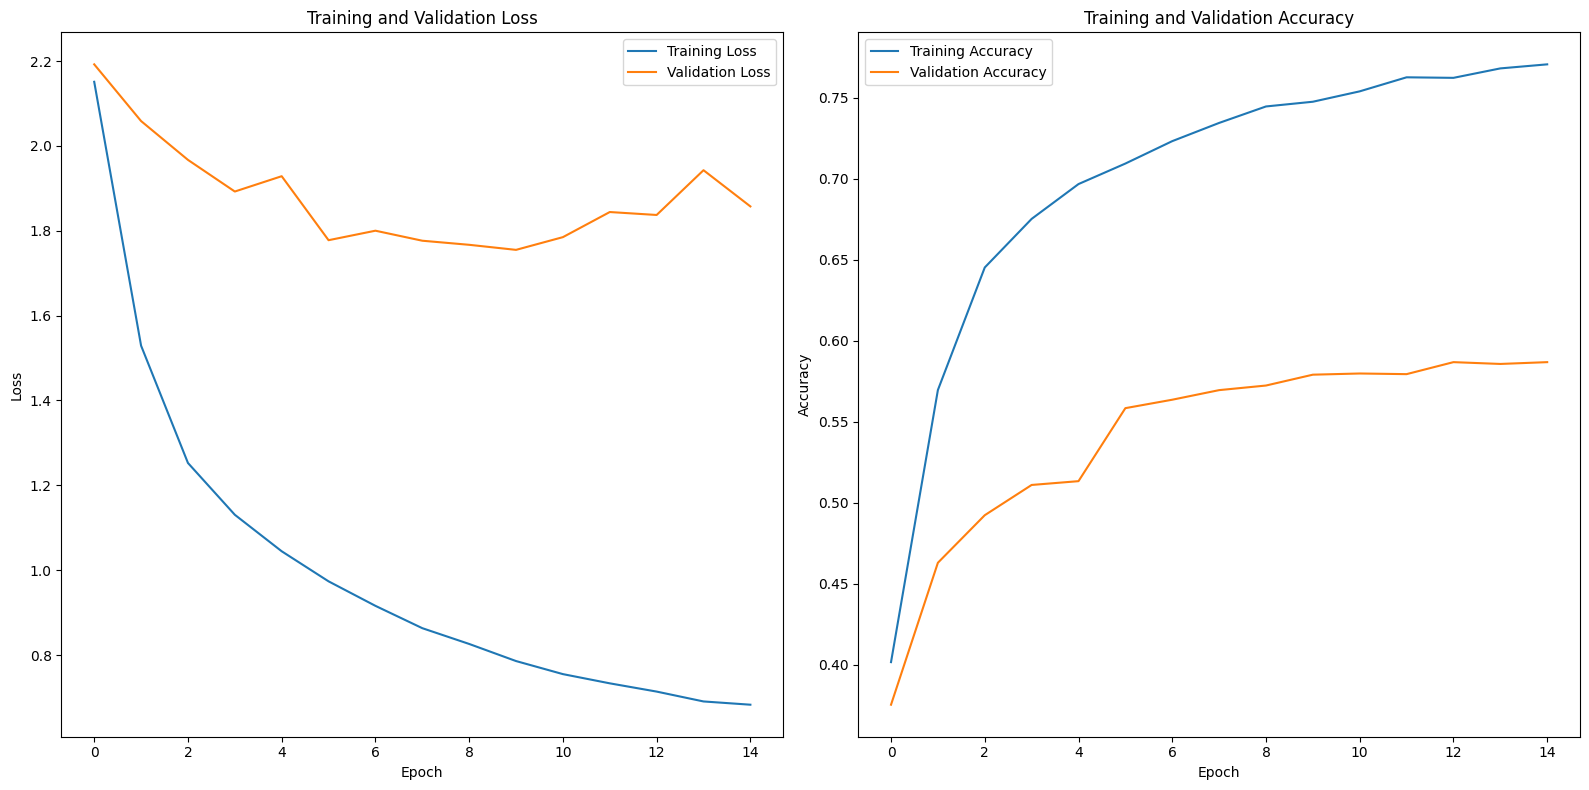

Object saved: output/1.00/data/Classification/models/model_neural_network_v1.00_.pkl
Evaluated Neural Network: Accuracy=0.579, F1=0.593


In [13]:
print("Training Neural Network...")

# Define model architecture
inputs = Input(shape=(X_TRAIN.shape[1],))
x = Dense(100, activation="selu")(inputs)
x = Dense(100, activation="selu")(x)
x = Dense(100, activation="selu")(x)
x = Dense(100, activation="selu")(x)
x = Dense(100, activation="selu")(x)
x = Dense(100, activation="selu")(x)
outputs = Dense(Y_ENC_TRAIN.shape[1], activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train with early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(
    X_TRAIN,
    Y_ENC_TRAIN,
    epochs=200,
    batch_size=256,
    validation_data=(X_TEST_REDUCED, Y_ENC_TEST_REDUCED),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.tight_layout()
save_plot("neural_network_training_history")
plt.show()

# Make predictions
nn_results = model.predict(X_TEST_REDUCED, verbose=0)
y_pred_nn = onehot_encoder.inverse_transform(nn_results).ravel()

evaluate_model(NEURAL_NET, Y_TEST_REDUCED_DF, y_pred_nn, model)

## LightGBM

In [14]:
print("Training LightGBM...")

# Create LightGBM dataset
train_data = lgb.Dataset(X_TRAIN, label=Y_TRAIN_DF)

# LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': len(Y_TRAIN_DF.unique()),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Train model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data],
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
)

# Make predictions
y_pred_lgb_proba = lgb_model.predict(X_TEST_REDUCED, num_iteration=lgb_model.best_iteration)
y_pred_lgb = np.argmax(y_pred_lgb_proba, axis=1)

evaluate_model(LIGHTGBM, Y_TEST_REDUCED_DF, y_pred_lgb, lgb_model)

Training LightGBM...


/Users/Khaled.Alabsi/projects/PhD_Project/.venv/lib/python3.11/site-packages/lightgbm/callback.py:347: UserWarning: Only training set found, disabling early stopping.
  _log_warning("Only training set found, disabling early stopping.")


Object saved: output/1.00/data/Classification/models/model_lightgbm_v1.00_.pkl
Evaluated LightGBM: Accuracy=0.578, F1=0.605


## Extra Trees (Extremely Randomized Trees)

In [15]:
print("Training Extra Trees...")

# Extra Trees Classifier
et = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

et.fit(X_TRAIN, Y_TRAIN_DF)
y_pred_et = et.predict(X_TEST_REDUCED)

evaluate_model(EXTRA_TREES, Y_TEST_REDUCED_DF, y_pred_et, et)

Training Extra Trees...
Object saved: output/1.00/data/Classification/models/model_extra_trees_v1.00_.pkl
Evaluated Extra Trees: Accuracy=0.534, F1=0.558
Object saved: output/1.00/data/Classification/models/model_extra_trees_v1.00_.pkl
Evaluated Extra Trees: Accuracy=0.534, F1=0.558


## Gradient Boosting

In [16]:
print("Training Gradient Boosting...")

# Gradient Boosting Classifier - Optimized for faster training
gb = GradientBoostingClassifier(
    n_estimators=50,        # Reduced from 100 to 50
    learning_rate=0.2,      # Increased from 0.1 to 0.2 for faster convergence
    max_depth=4,            # Reduced from 6 to 4
    min_samples_split=10,   # Increased from 5 to 10
    min_samples_leaf=5,     # Increased from 2 to 5
    subsample=0.8,          # Add subsampling for faster training
    random_state=42
)

gb.fit(X_TRAIN, Y_TRAIN_DF)
y_pred_gb = gb.predict(X_TEST_REDUCED)

evaluate_model(GRADIENT_BOOSTING, Y_TEST_REDUCED_DF, y_pred_gb, gb)

Training Gradient Boosting...
Object saved: output/1.00/data/Classification/models/model_gradient_boosting_v1.00_.pkl
Evaluated Gradient Boosting: Accuracy=0.556, F1=0.575
Object saved: output/1.00/data/Classification/models/model_gradient_boosting_v1.00_.pkl
Evaluated Gradient Boosting: Accuracy=0.556, F1=0.575


## Support Vector Machine (SVM)

In [17]:
print("Training SVM...")

# Support Vector Machine with RBF kernel
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    probability=True  # Enable probability estimates
)

svm.fit(X_TRAIN, Y_TRAIN_DF)
y_pred_svm = svm.predict(X_TEST_REDUCED)

evaluate_model(SVM, Y_TEST_REDUCED_DF, y_pred_svm, svm)

Training SVM...
Object saved: output/1.00/data/Classification/models/model_svm_v1.00_.pkl
Evaluated SVM: Accuracy=0.470, F1=0.474
Object saved: output/1.00/data/Classification/models/model_svm_v1.00_.pkl
Evaluated SVM: Accuracy=0.470, F1=0.474


## K-Nearest Neighbors (KNN)

In [18]:
print("Training K-Nearest Neighbors...")

# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    metric='minkowski',
    n_jobs=-1
)

knn.fit(X_TRAIN, Y_TRAIN_DF)
y_pred_knn = knn.predict(X_TEST_REDUCED)

evaluate_model(KNN, Y_TEST_REDUCED_DF, y_pred_knn, knn)

Training K-Nearest Neighbors...
Object saved: output/1.00/data/Classification/models/model_k-nearest_neighbors_v1.00_.pkl
Evaluated K-Nearest Neighbors: Accuracy=0.396, F1=0.414
Object saved: output/1.00/data/Classification/models/model_k-nearest_neighbors_v1.00_.pkl
Evaluated K-Nearest Neighbors: Accuracy=0.396, F1=0.414


## Ensemble (Voting Classifier)

In [19]:
print("Training Ensemble (Voting Classifier)...")

# Create ensemble of best performing models
ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', xgb.XGBClassifier(random_state=42)),
        ('et', ExtraTreesClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
    ],
    voting='soft'  # Use probability-based voting
)

ensemble.fit(X_TRAIN, Y_TRAIN_DF)
y_pred_ensemble = ensemble.predict(X_TEST_REDUCED)

evaluate_model(ENSEMBLE_VOTING, Y_TEST_REDUCED_DF, y_pred_ensemble, ensemble)

Training Ensemble (Voting Classifier)...
Object saved: output/1.00/data/Classification/models/model_ensemble_(voting)_v1.00_.pkl
Evaluated Ensemble (Voting): Accuracy=0.586, F1=0.612
Object saved: output/1.00/data/Classification/models/model_ensemble_(voting)_v1.00_.pkl
Evaluated Ensemble (Voting): Accuracy=0.586, F1=0.612


## Cross-Validation Analysis

Performing cross-validation analysis...
Cross-validating Random Forest...
Cross-validating XGBoost...
Cross-validating XGBoost...
Cross-validating Extra Trees...
Cross-validating Extra Trees...
Cross-validating Gradient Boosting...
Cross-validating Gradient Boosting...
Cross-validating SVM...
Cross-validating SVM...
Cross-validating KNN...
Cross-validating KNN...

=== Cross-Validation Results ===
+----+-------------------+-----------+----------+
|    | Model             |   CV_Mean |   CV_Std |
+====+===================+===========+==========+
|  0 | Random Forest     |     0.724 |    0.008 |
+----+-------------------+-----------+----------+
|  1 | XGBoost           |     0.781 |    0.007 |
+----+-------------------+-----------+----------+
|  2 | Extra Trees       |     0.735 |    0.005 |
+----+-------------------+-----------+----------+
|  3 | Gradient Boosting |     0.759 |    0.008 |
+----+-------------------+-----------+----------+
|  4 | SVM               |     0.602 |    0.007 |


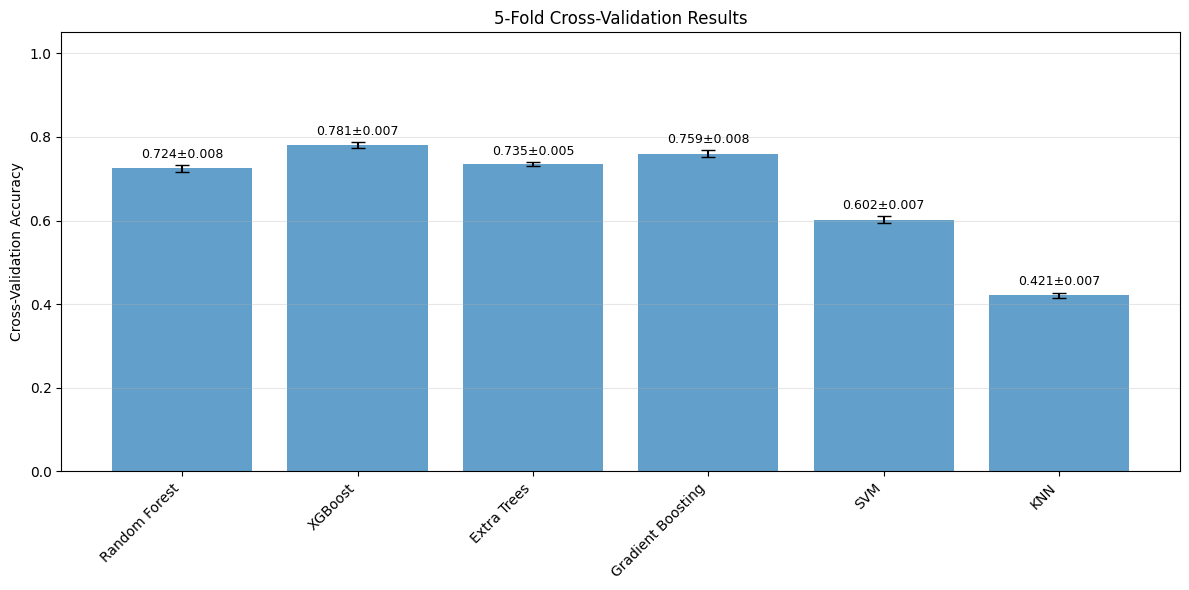

In [20]:
print("Performing cross-validation analysis...")

# Define models for cross-validation
cv_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
}

# Perform 5-fold stratified cross-validation
cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in cv_models.items():
    print(f"Cross-validating {name}...")
    scores = cross_val_score(model, X_TRAIN, Y_TRAIN_DF, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }

# Create cross-validation results DataFrame
cv_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'CV_Mean': [cv_results[model]['mean'] for model in cv_results.keys()],
    'CV_Std': [cv_results[model]['std'] for model in cv_results.keys()]
})

print("\n=== Cross-Validation Results ===")
print(tabulate(cv_df, headers="keys", tablefmt="grid", floatfmt=".3f"))

# Plot cross-validation results
plt.figure(figsize=(12, 6))
models = list(cv_results.keys())
means = [cv_results[model]['mean'] for model in models]
stds = [cv_results[model]['std'] for model in models]

bars = plt.bar(models, means, yerr=stds, capsize=5, alpha=0.7)
plt.ylabel('Cross-Validation Accuracy')
plt.title('5-Fold Cross-Validation Results')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01, 
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
save_plot('cross_validation_results')
plt.show()

## Feature Importance Analysis

Analyzing feature importance...
Plot saved: output/1.00/data/Classification/plots/feature_analysis/feature_importance_comparison_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/feature_analysis/feature_importance_comparison_v1.00_.png


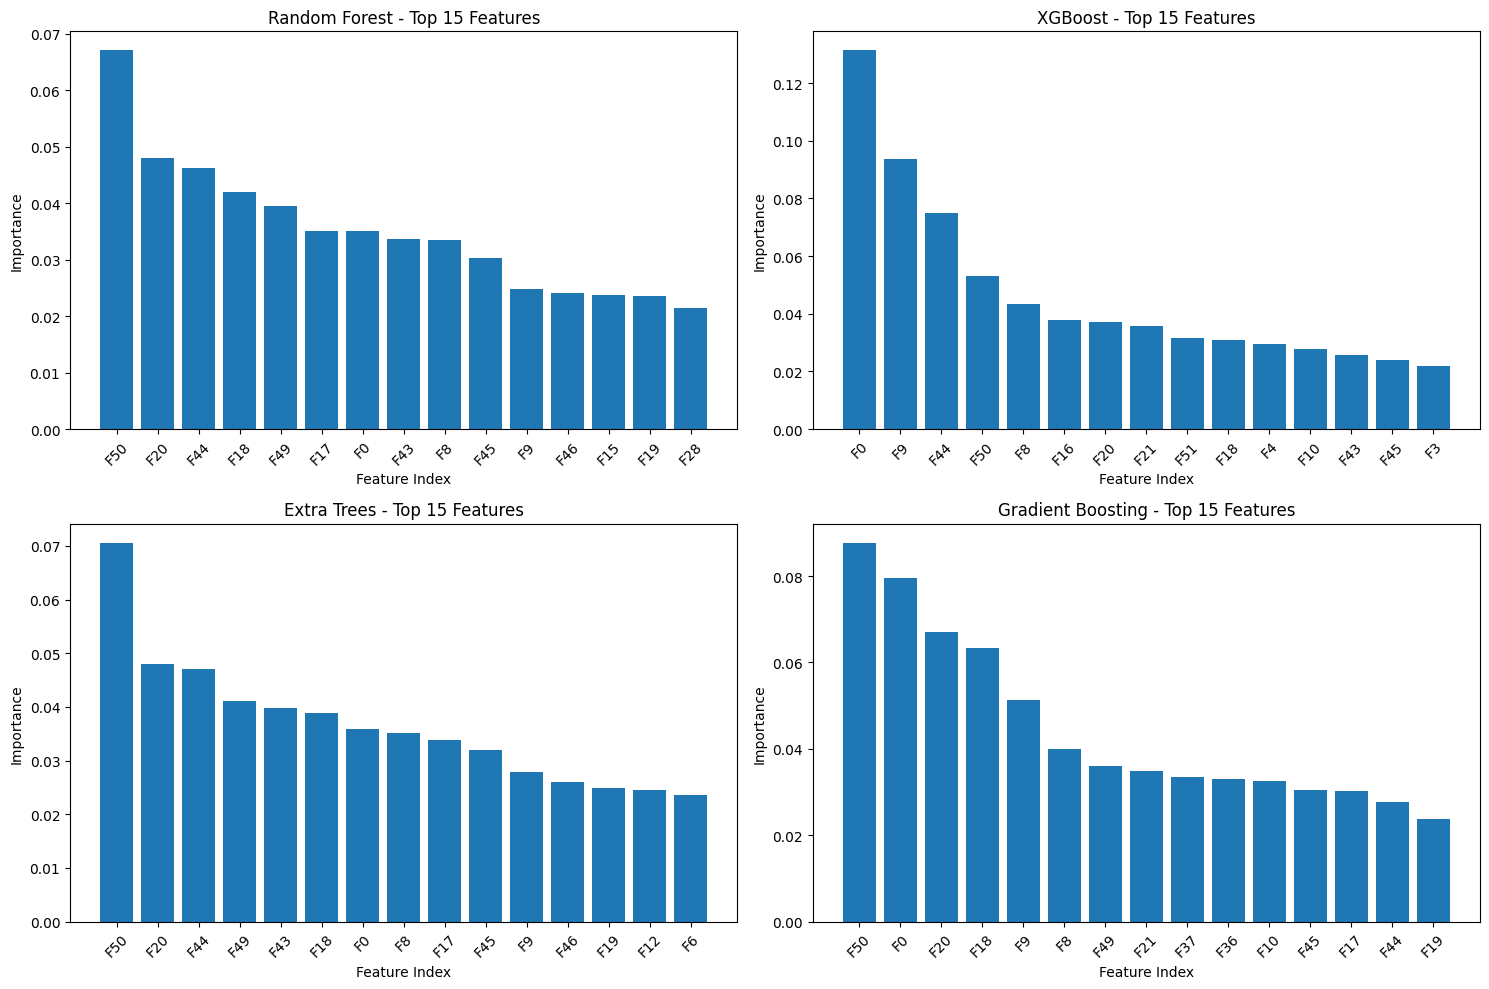


=== Top 20 Most Important Features (Average across models) ===
+----+------------+-----------+-----------------+-----------+---------------+---------------------+
|    | Feature    |   Average |   Random Forest |   XGBoost |   Extra Trees |   Gradient Boosting |
+====+============+===========+=================+===========+===============+=====================+
|  0 | Feature_0  |    0.0705 |          0.0351 |    0.1314 |        0.0358 |              0.0797 |
+----+------------+-----------+-----------------+-----------+---------------+---------------------+
| 50 | Feature_50 |    0.0696 |          0.0671 |    0.0531 |        0.0706 |              0.0877 |
+----+------------+-----------+-----------------+-----------+---------------+---------------------+
| 20 | Feature_20 |    0.0500 |          0.0480 |    0.0371 |        0.0479 |              0.0671 |
+----+------------+-----------+-----------------+-----------+---------------+---------------------+
|  9 | Feature_9  |    0.0495 |     

In [21]:
print("Analyzing feature importance...")

# Get feature importance from tree-based models
feature_importance_models = {
    'Random Forest': rf,
    'XGBoost': xg,
    'Extra Trees': et,
    'Gradient Boosting': gb
}

feature_names = [f'Feature_{i}' for i in range(X_TRAIN.shape[1])]

# Create feature importance comparison
plt.figure(figsize=(15, 10))

for i, (model_name, model) in enumerate(feature_importance_models.items(), 1):
    plt.subplot(2, 2, i)
    
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        continue
    
    # Get top 15 features
    indices = np.argsort(importances)[::-1][:15]
    
    plt.bar(range(15), importances[indices])
    plt.title(f'{model_name} - Top 15 Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.xticks(range(15), [f'F{indices[j]}' for j in range(15)], rotation=45)

plt.tight_layout()
save_plot('feature_importance_comparison')
plt.show()

# Aggregate feature importance across models
importance_df = pd.DataFrame()
for model_name, model in feature_importance_models.items():
    if hasattr(model, 'feature_importances_'):
        importance_df[model_name] = model.feature_importances_

# Calculate average importance
importance_df['Average'] = importance_df.mean(axis=1)
importance_df['Feature'] = feature_names

# Sort by average importance and get top 20
top_features = importance_df.nlargest(20, 'Average')

print("\n=== Top 20 Most Important Features (Average across models) ===")
print(tabulate(top_features[['Feature', 'Average', 'Random Forest', 'XGBoost', 'Extra Trees', 'Gradient Boosting']], 
               headers="keys", tablefmt="grid", floatfmt=".4f"))

save_dataframe(top_features, "top_features_importance", "classification")

## Model Ranking and Recommendations

Generating model rankings and recommendations...

=== Final Model Rankings ===
+----+--------+---------------------+-------------------+------------+------------+-------------+----------+--------------------+------------+
|    |   Rank | Model               |   Composite_Score |   Accuracy |   F1-Score |   Precision |   Recall |   False Alarm Rate |   CV_Score |
+====+========+=====================+===================+============+============+=============+==========+====================+============+
|  0 |  1.000 | Ensemble (Voting)   |             0.664 |      0.586 |      0.612 |       0.769 |    0.567 |              0.022 |    nan     |
+----+--------+---------------------+-------------------+------------+------------+-------------+----------+--------------------+------------+
|  1 |  2.000 | LightGBM            |             0.656 |      0.578 |      0.605 |       0.751 |    0.560 |              0.022 |    nan     |
+----+--------+---------------------+-------------------+------

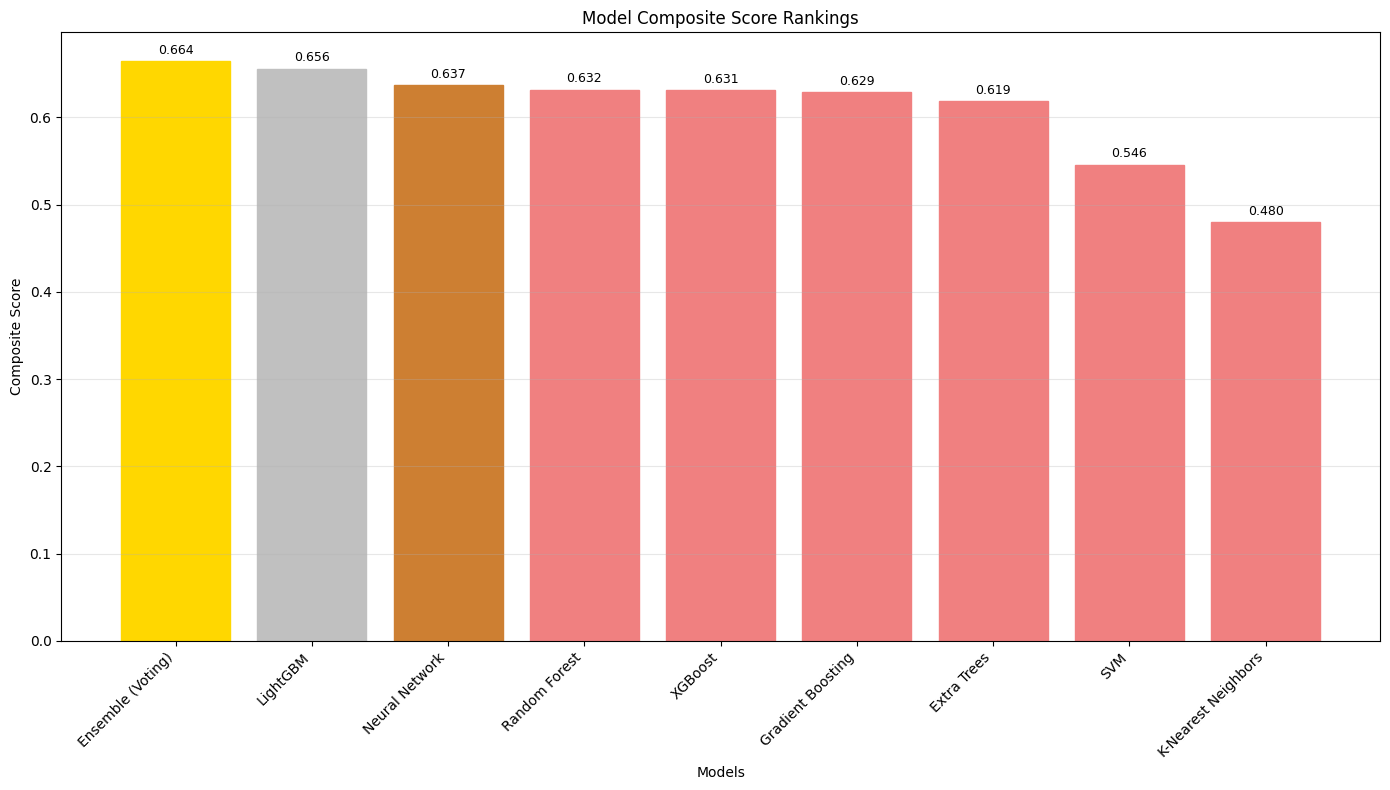

In [22]:
print("Generating model rankings and recommendations...")

# Create comprehensive ranking system
results_df = pd.DataFrame(models_results_list)

# Normalize metrics (higher is better for most, lower is better for False Alarm Rate)
ranking_df = results_df.copy()
ranking_df['FAR_Score'] = 1 - ranking_df['False Alarm Rate']  # Invert FAR for ranking

# Calculate composite scores
weights = {
    'Accuracy': 0.25,
    'Precision': 0.20,
    'Recall': 0.20,
    'F1-Score': 0.25,
    'FAR_Score': 0.10
}

ranking_df['Composite_Score'] = (
    weights['Accuracy'] * ranking_df['Accuracy'] +
    weights['Precision'] * ranking_df['Precision'] +
    weights['Recall'] * ranking_df['Recall'] +
    weights['F1-Score'] * ranking_df['F1-Score'] +
    weights['FAR_Score'] * ranking_df['FAR_Score']
)

# Rank models
ranking_df['Rank'] = ranking_df['Composite_Score'].rank(ascending=False, method='min')
ranking_df = ranking_df.sort_values('Rank')

# Add cross-validation scores if available
if 'cv_results' in locals():
    cv_scores = pd.DataFrame({
        'Model': list(cv_results.keys()),
        'CV_Score': [cv_results[model]['mean'] for model in cv_results.keys()]
    })
    ranking_df = ranking_df.merge(cv_scores, on='Model', how='left')

print("\n=== Final Model Rankings ===")
display_cols = ['Rank', 'Model', 'Composite_Score', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'False Alarm Rate']
if 'CV_Score' in ranking_df.columns:
    display_cols.append('CV_Score')

print(tabulate(ranking_df[display_cols], headers="keys", tablefmt="grid", floatfmt=".3f"))

# Performance analysis by categories
print("\n=== Performance Categories ===")
categories = {
    'Excellent (>90%)': ranking_df[ranking_df['Accuracy'] > 0.9],
    'Good (80-90%)': ranking_df[(ranking_df['Accuracy'] >= 0.8) & (ranking_df['Accuracy'] <= 0.9)],
    'Fair (70-80%)': ranking_df[(ranking_df['Accuracy'] >= 0.7) & (ranking_df['Accuracy'] < 0.8)],
    'Poor (<70%)': ranking_df[ranking_df['Accuracy'] < 0.7]
}

for category, models in categories.items():
    if not models.empty:
        print(f"\n{category}:")
        for _, model in models.iterrows():
            print(f"  - {model['Model']}: {model['Accuracy']:.3f} accuracy")

# Model recommendations
print("\n=== Model Recommendations ===")
best_overall = ranking_df.iloc[0]
best_accuracy = ranking_df.loc[ranking_df['Accuracy'].idxmax()]
best_f1 = ranking_df.loc[ranking_df['F1-Score'].idxmax()]
lowest_far = ranking_df.loc[ranking_df['False Alarm Rate'].idxmin()]

print(f"🏆 Best Overall Performance: {best_overall['Model']} (Composite Score: {best_overall['Composite_Score']:.3f})")
print(f"🎯 Highest Accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.3f})")
print(f"⚖️ Best F1-Score: {best_f1['Model']} ({best_f1['F1-Score']:.3f})")
print(f"🚨 Lowest False Alarm Rate: {lowest_far['Model']} ({lowest_far['False Alarm Rate']:.3f})")

# Save comprehensive results
save_dataframe(ranking_df, "final_model_rankings", "classification")

# Visualization of rankings
plt.figure(figsize=(14, 8))
bars = plt.bar(ranking_df['Model'], ranking_df['Composite_Score'])
plt.title('Model Composite Score Rankings')
plt.ylabel('Composite Score')
plt.xlabel('Models')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Color bars by performance tier
colors = ['gold', 'silver', '#CD7F32', 'lightcoral']  # Gold, Silver, Bronze, Red
for i, bar in enumerate(bars):
    if i == 0:
        bar.set_color('gold')
    elif i == 1:
        bar.set_color('silver')
    elif i == 2:
        bar.set_color('#CD7F32')
    else:
        bar.set_color('lightcoral')

# Add value labels
for bar, score in zip(bars, ranking_df['Composite_Score']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
save_plot('model_composite_rankings')
plt.show()

## Results Analysis and Visualization

In [23]:
# Create summary results table
model_classification_average = pd.DataFrame(models_results_list)
save_dataframe(model_classification_average, "model_results_average", "classification")

print("\n=== Model Comparison Summary ===")
print(tabulate(model_classification_average, headers="keys", tablefmt="grid", floatfmt=".3f"))

Data saved: output/1.00/data/Classification/model_analysis/model_results_average_classification_v1.00_.csv

=== Model Comparison Summary ===
+----+---------------------+------------+-------------+----------+------------+--------------------+
|    | Model               |   Accuracy |   Precision |   Recall |   F1-Score |   False Alarm Rate |
+====+=====================+============+=============+==========+============+====================+
|  0 | Random Forest       |      0.554 |       0.719 |    0.535 |      0.578 |              0.023 |
+----+---------------------+------------+-------------+----------+------------+--------------------+
|  1 | XGBoost             |      0.555 |       0.720 |    0.536 |      0.574 |              0.023 |
+----+---------------------+------------+-------------+----------+------------+--------------------+
|  2 | Neural Network      |      0.579 |       0.662 |    0.569 |      0.593 |              0.022 |
+----+---------------------+------------+----------

Plot saved: output/1.00/data/Classification/plots/general/metric_average_v1.00_.png


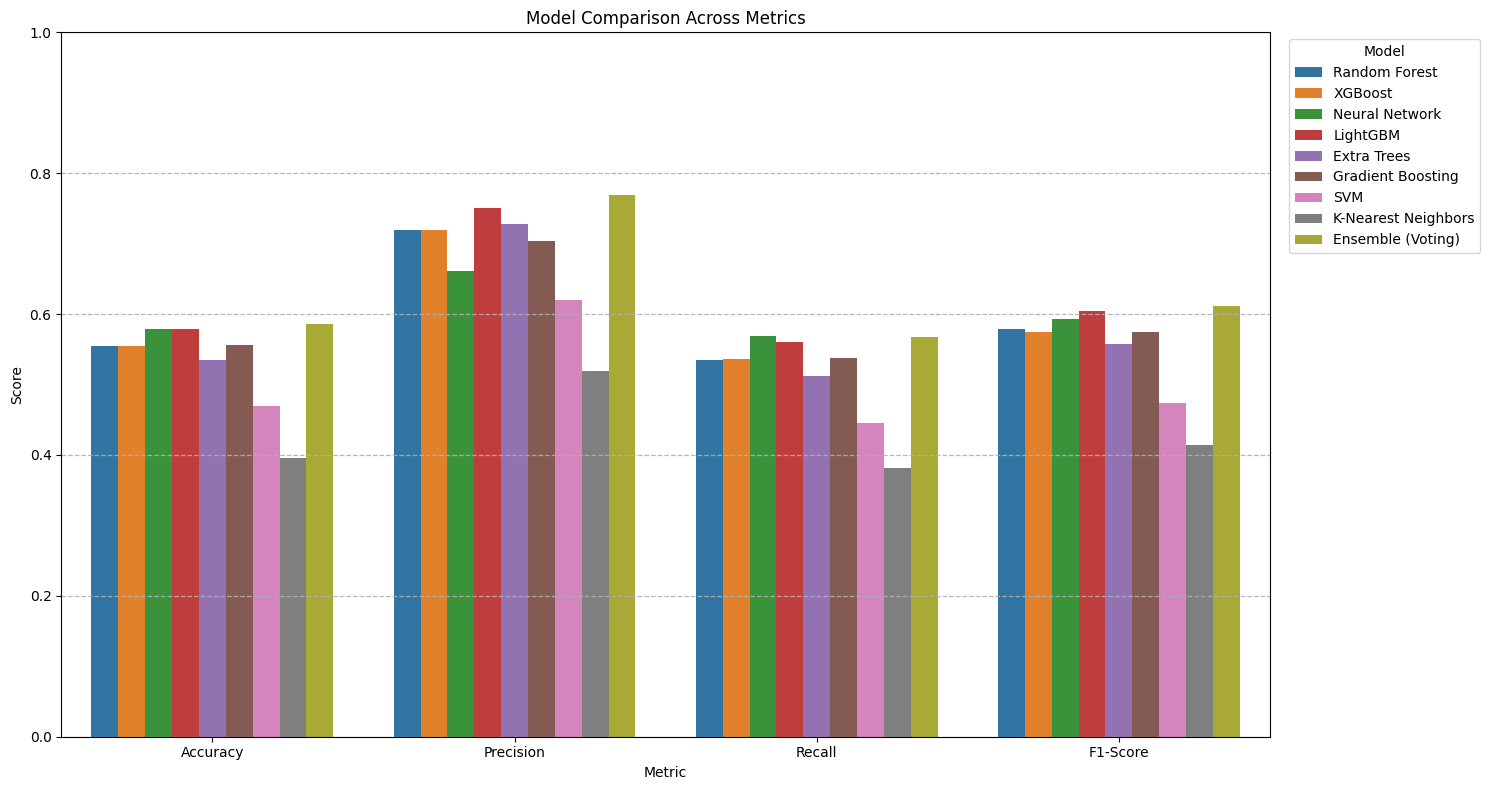

Plot saved: output/1.00/data/Classification/plots/model_comparison/comprehensive_model_comparison_v1.00_.png


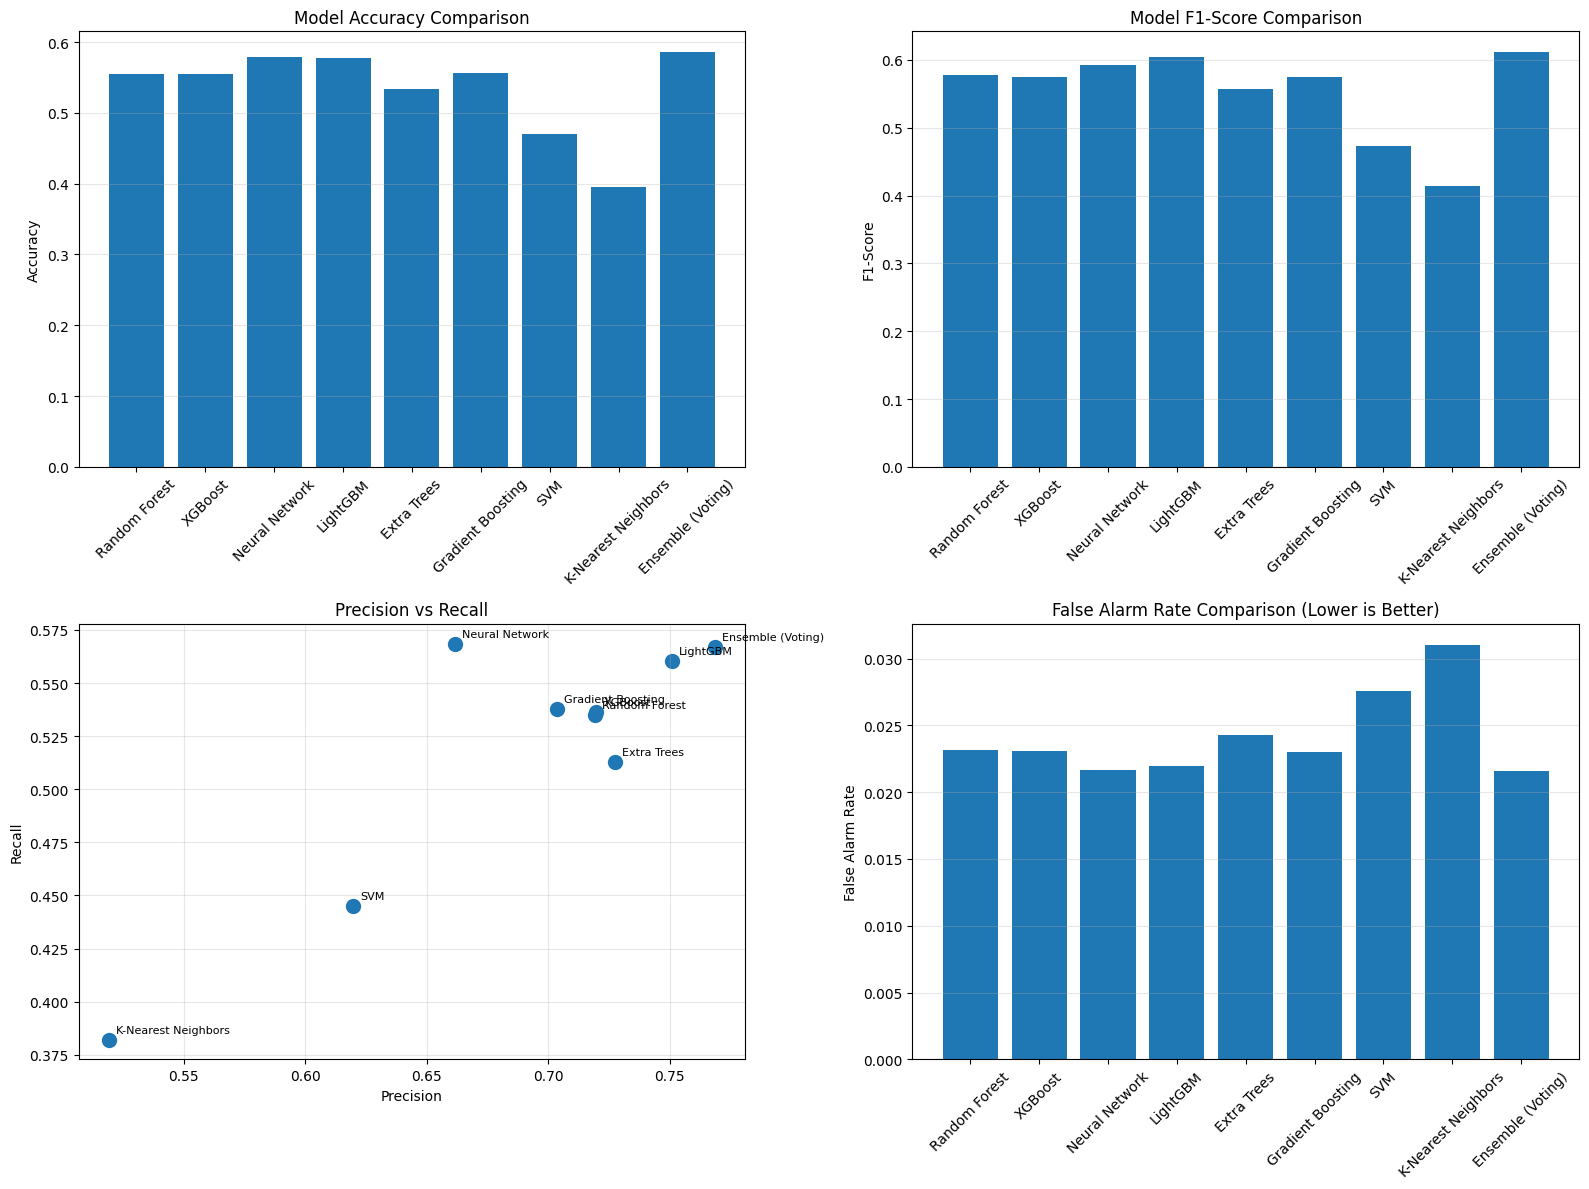

In [24]:
def plot_models_metrics_comparison(models_results, plot_name: str = "metric_average") -> None:
    """Plot model comparison across metrics."""
    results_df = pd.DataFrame(models_results)
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    
    melted_df = results_df.melt(
        id_vars="Model",
        value_vars=metrics,
        var_name="Metric",
        value_name="Score",
    )

    plt.figure(figsize=(15, 8))
    ax = sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model")
    ax.grid(axis="y", linestyle="--", linewidth=0.9, alpha=0.9)
    plt.title("Model Comparison Across Metrics")
    plt.ylim(0, 1.0)
    plt.legend(title="Model", bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    save_plot(plot_name)
    plt.show()

def plot_comprehensive_model_comparison(models_results):
    """Create comprehensive model comparison plots."""
    results_df = pd.DataFrame(models_results)
    
    # 1. Overall performance radar chart
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy ranking
    axes[0, 0].bar(results_df['Model'], results_df['Accuracy'])
    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # F1-Score ranking
    axes[0, 1].bar(results_df['Model'], results_df['F1-Score'])
    axes[0, 1].set_title('Model F1-Score Comparison')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Precision vs Recall scatter
    axes[1, 0].scatter(results_df['Precision'], results_df['Recall'], s=100)
    for i, model in enumerate(results_df['Model']):
        axes[1, 0].annotate(model, (results_df['Precision'].iloc[i], results_df['Recall'].iloc[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1, 0].set_xlabel('Precision')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_title('Precision vs Recall')
    axes[1, 0].grid(True, alpha=0.3)
    
    # False Alarm Rate comparison
    axes[1, 1].bar(results_df['Model'], results_df['False Alarm Rate'])
    axes[1, 1].set_title('False Alarm Rate Comparison (Lower is Better)')
    axes[1, 1].set_ylabel('False Alarm Rate')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    save_plot('comprehensive_model_comparison')
    plt.show()

# Generate enhanced visualizations
plot_models_metrics_comparison(models_results_list)
plot_comprehensive_model_comparison(models_results_list)

Plot saved: output/1.00/data/Classification/plots/confusion_matrices/confusion_matrix_random_forest_confusion_matrix_v1.00_.png


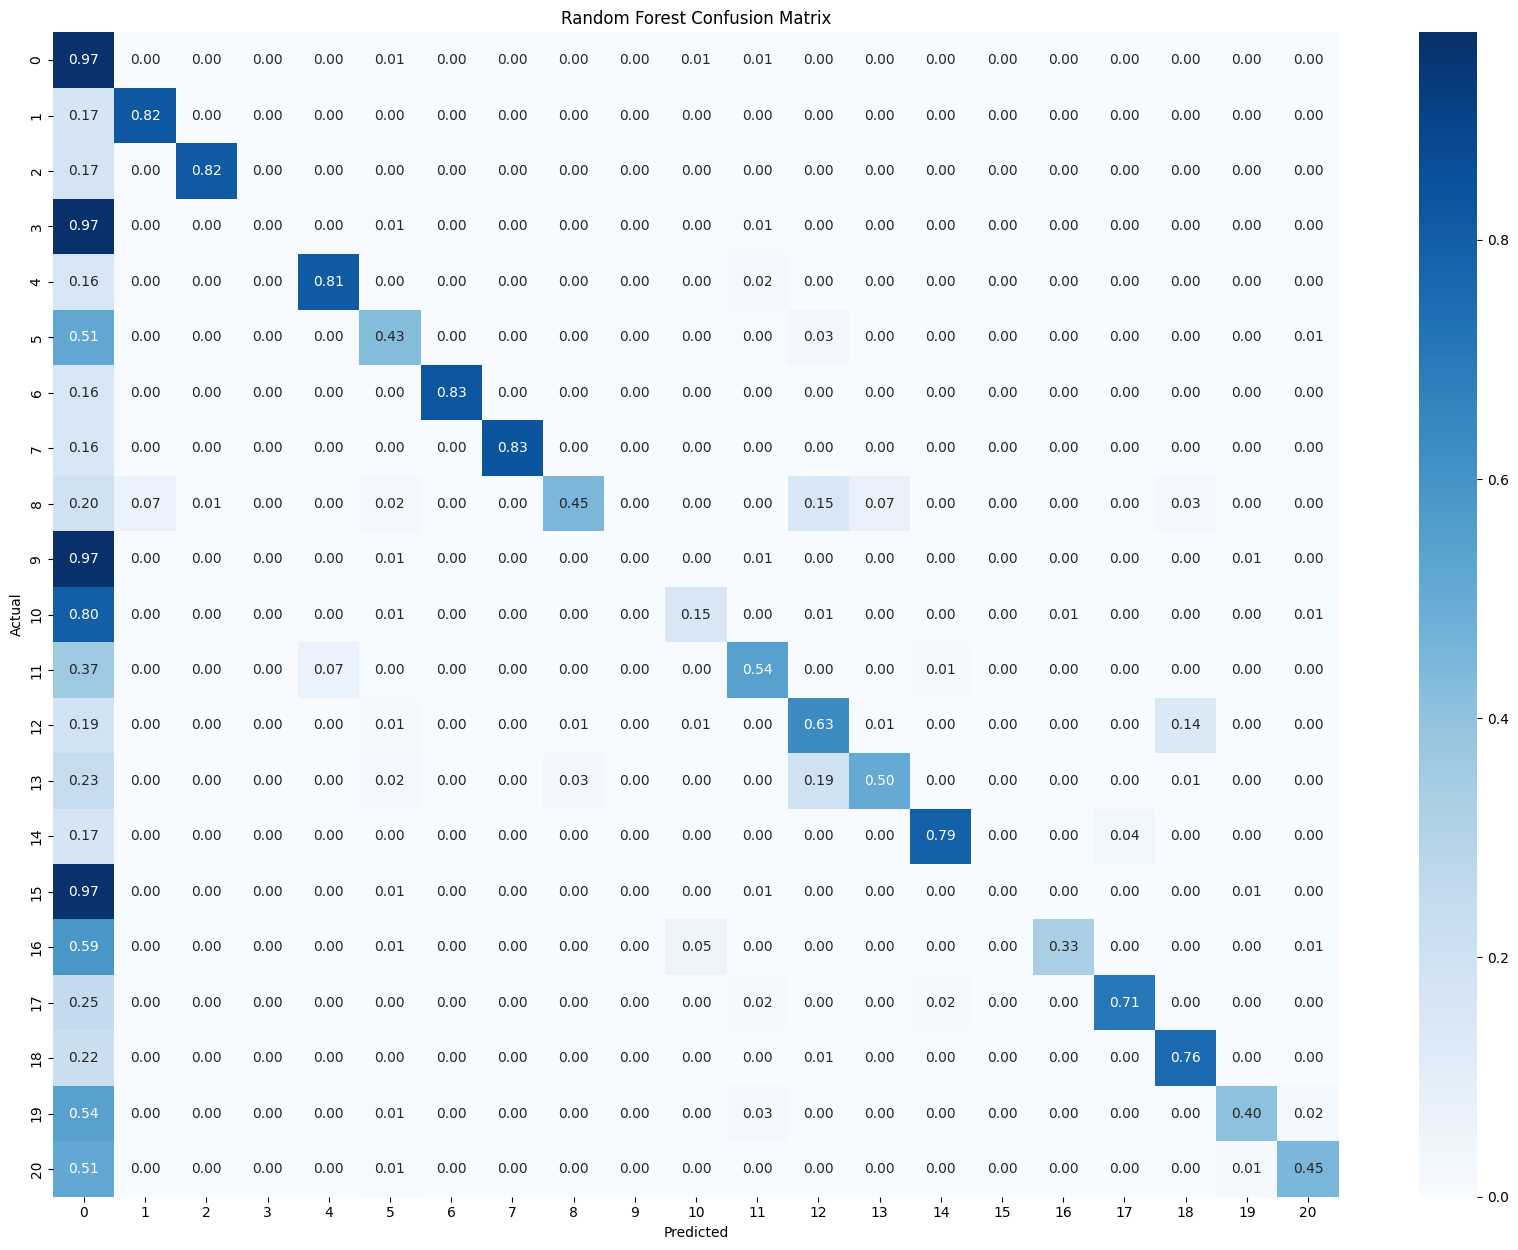

Plot saved: output/1.00/data/Classification/plots/confusion_matrices/confusion_matrix_xgboost_confusion_matrix_v1.00_.png


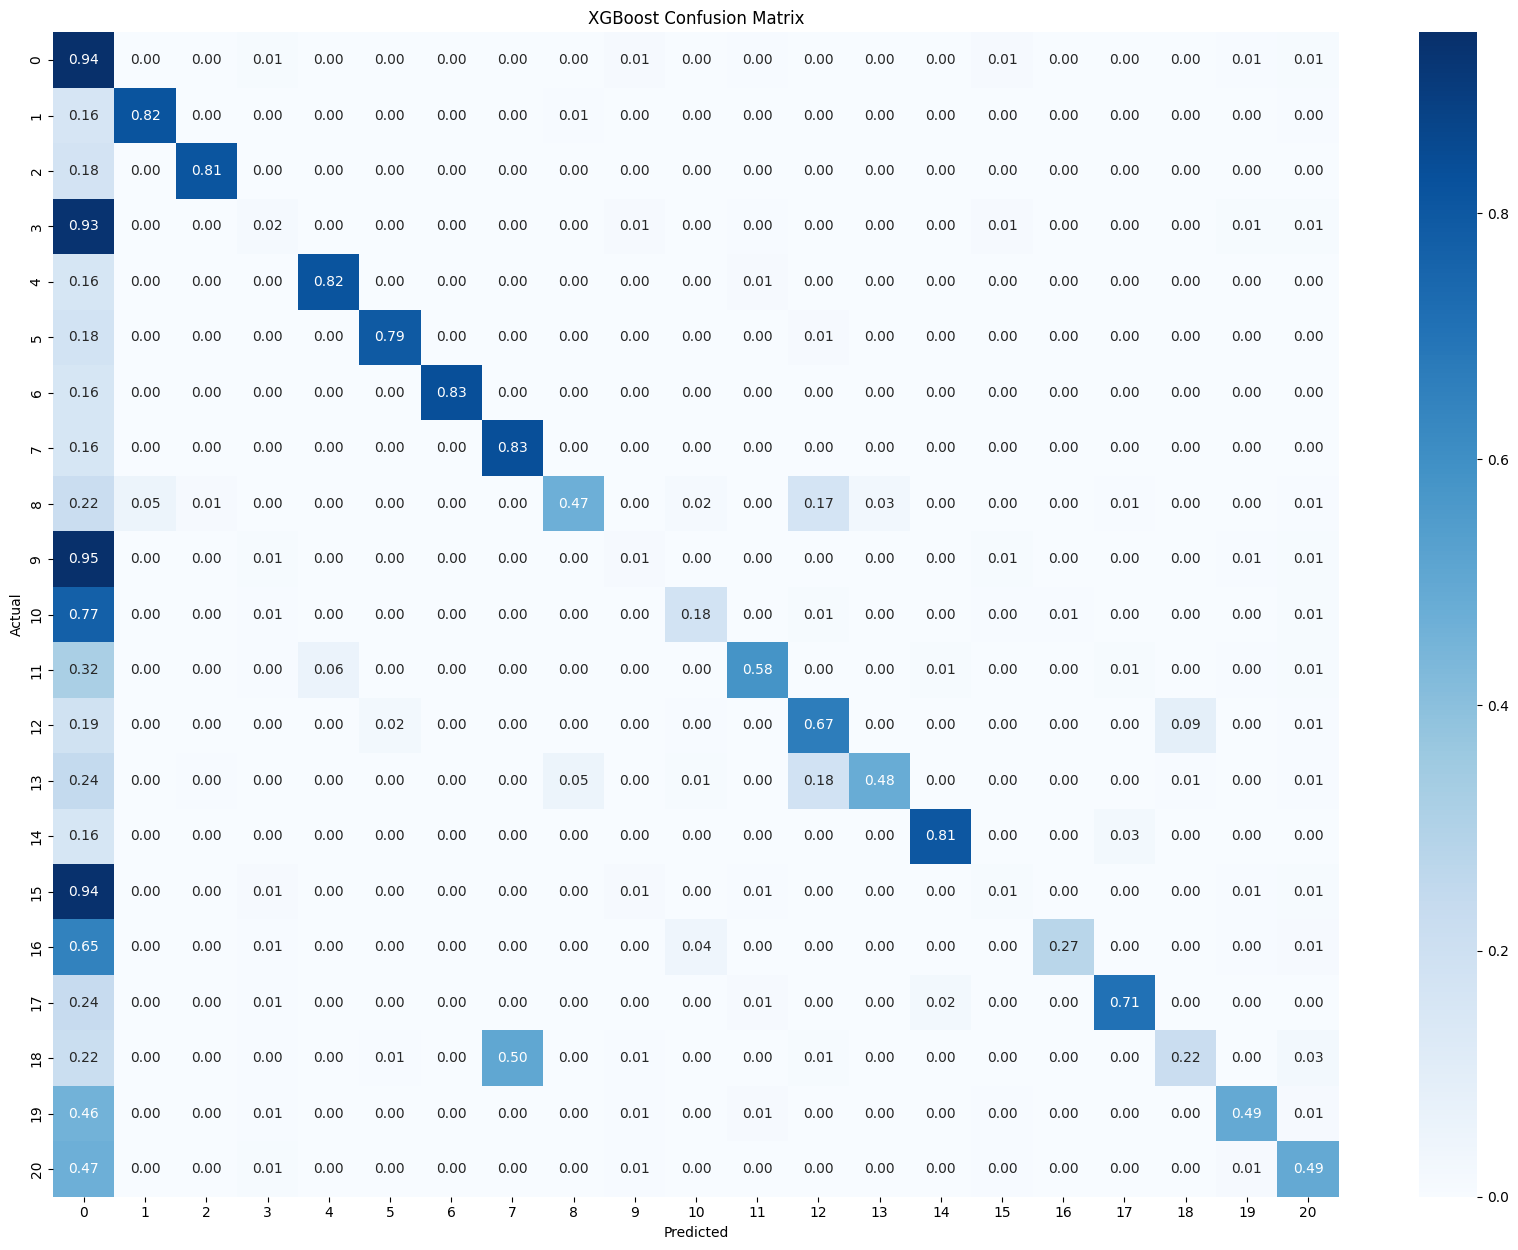

Plot saved: output/1.00/data/Classification/plots/confusion_matrices/confusion_matrix_neural_network_confusion_matrix_v1.00_.png


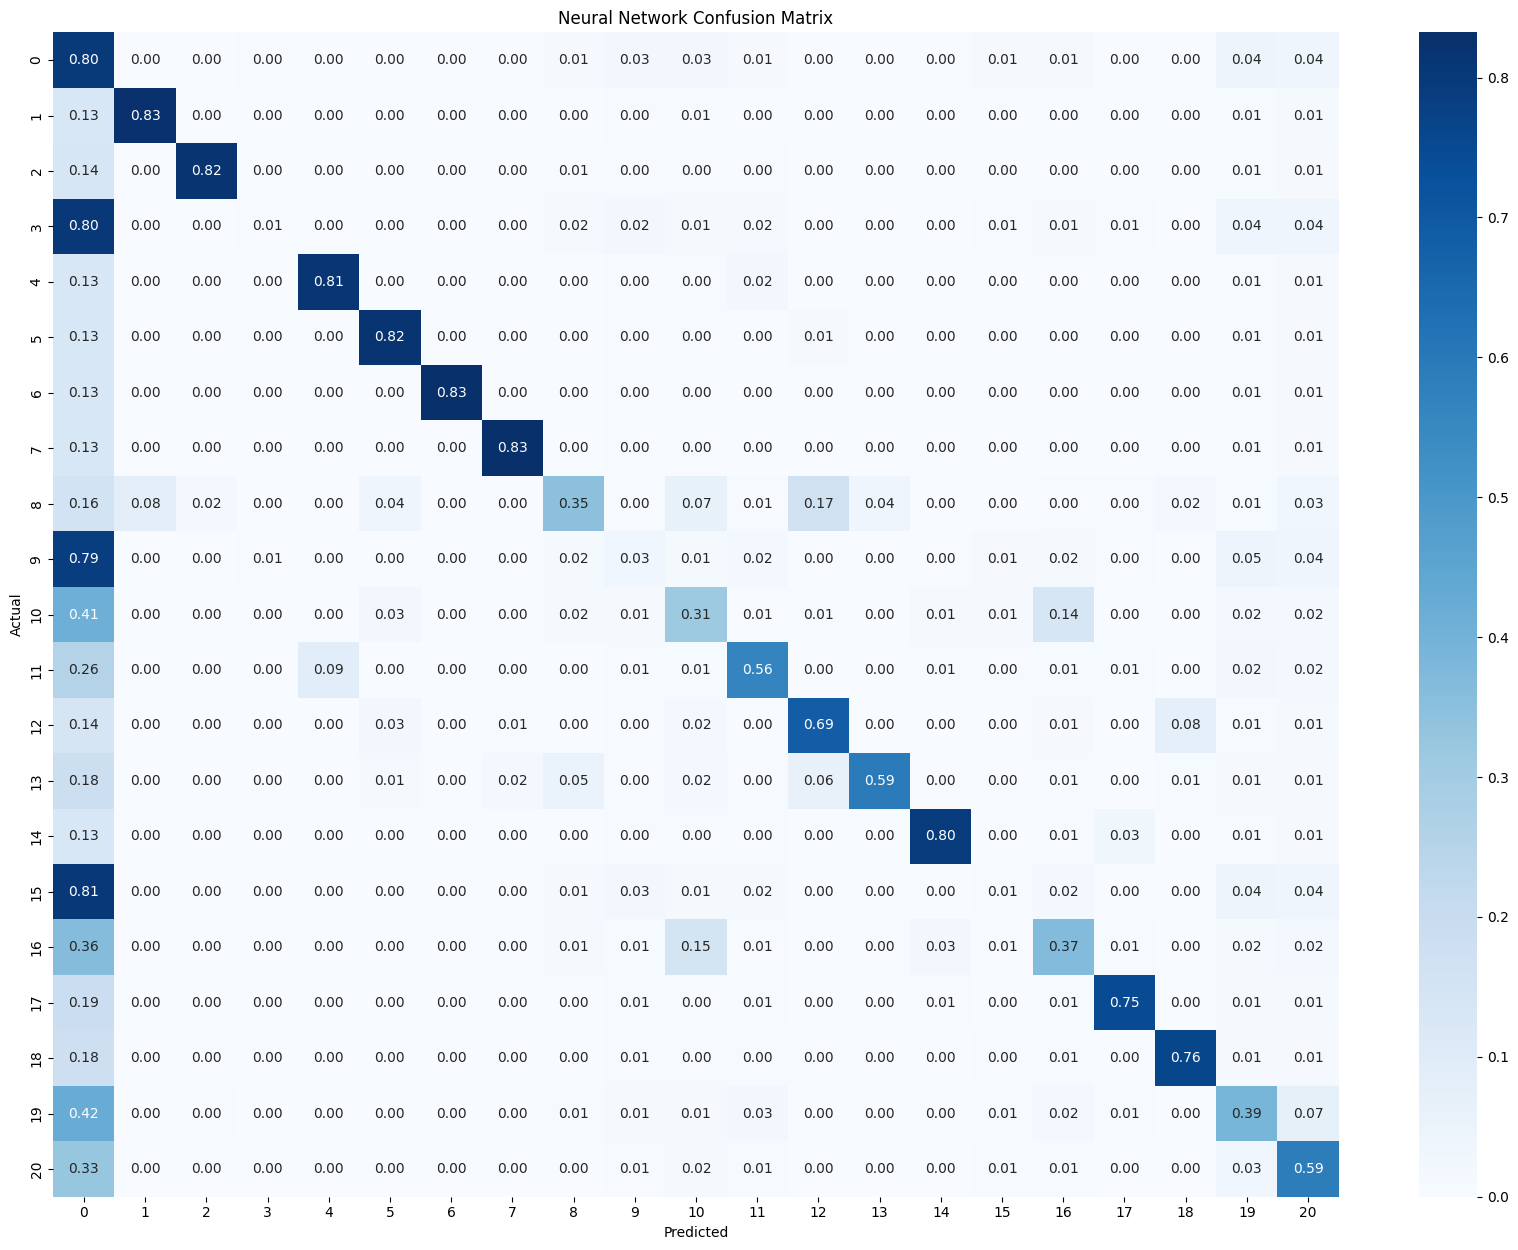

In [25]:
def plot_confusion_matrix(y_true, y_pred, title: str = "Confusion Matrix") -> None:
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    num_classes = cm.shape[0]

    width = max(8, num_classes * 0.8)
    height = max(6, num_classes * 0.6)

    plt.figure(figsize=(width, height))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    safe_title = title.replace(" ", "_").lower()
    save_plot(f"confusion_matrix_{safe_title}")
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(Y_TEST_REDUCED_DF, y_pred_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(Y_TEST_REDUCED_DF, y_pred_xg, "XGBoost Confusion Matrix")
plot_confusion_matrix(Y_TEST_REDUCED_DF, y_pred_nn, "Neural Network Confusion Matrix")

Data saved: output/1.00/data/Classification/per_class_analysis/random_forest_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_random_forest_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_random_forest_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

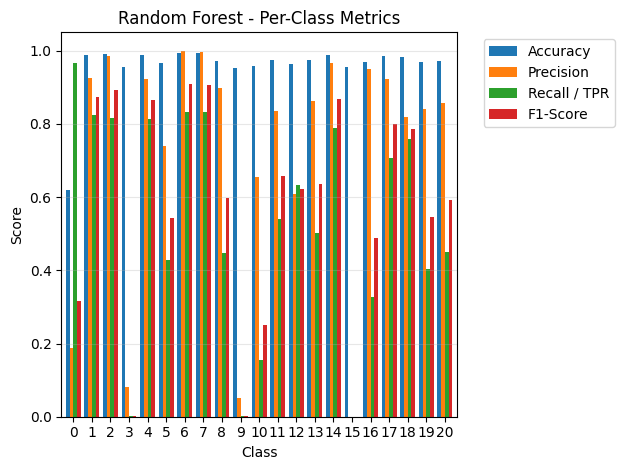

Data saved: output/1.00/data/Classification/per_class_analysis/xgboost_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_xgboost_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

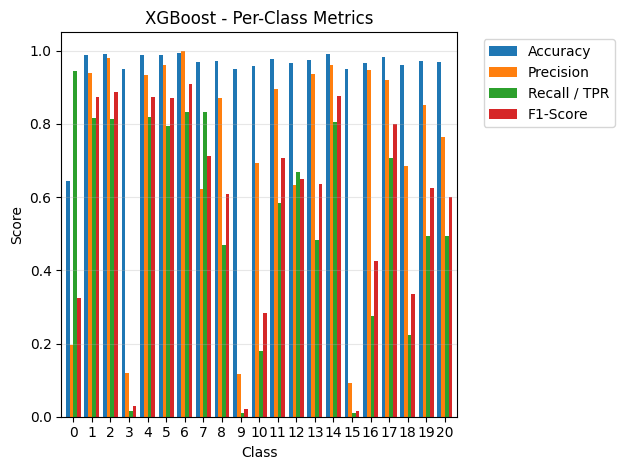

Data saved: output/1.00/data/Classification/per_class_analysis/neural_network_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_neural_network_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_neural_network_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

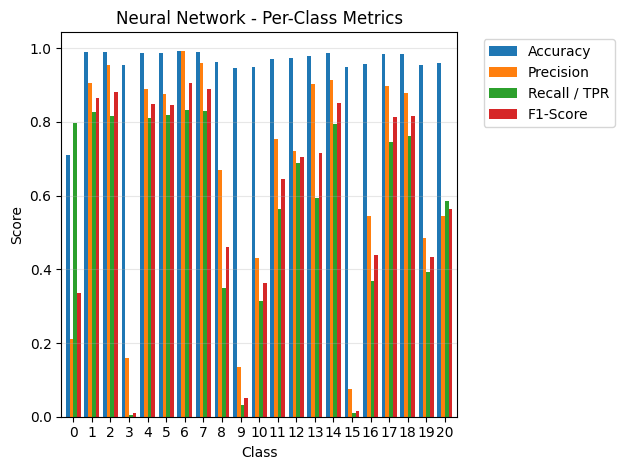

Data saved: output/1.00/data/Classification/per_class_analysis/lightgbm_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_lightgbm_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_lightgbm_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

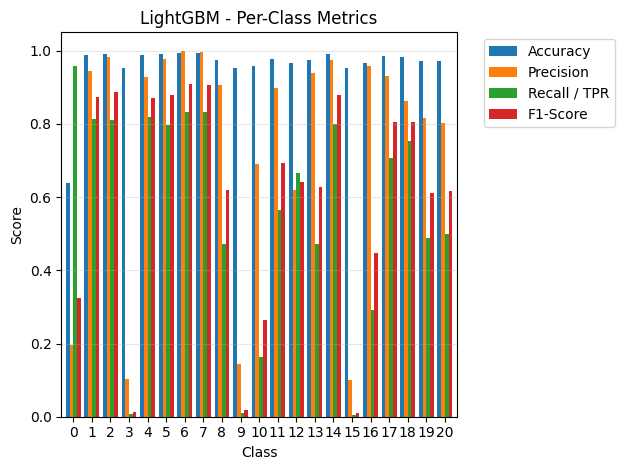

Data saved: output/1.00/data/Classification/per_class_analysis/extra_trees_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_extra_trees_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_extra_trees_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

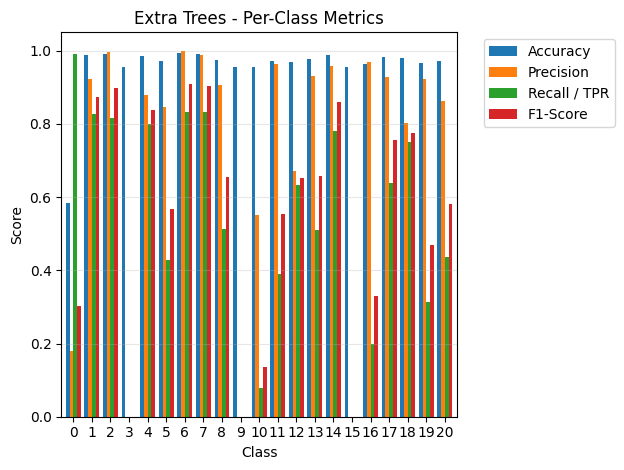

Data saved: output/1.00/data/Classification/per_class_analysis/gradient_boosting_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_gradient_boosting_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_gradient_boosting_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

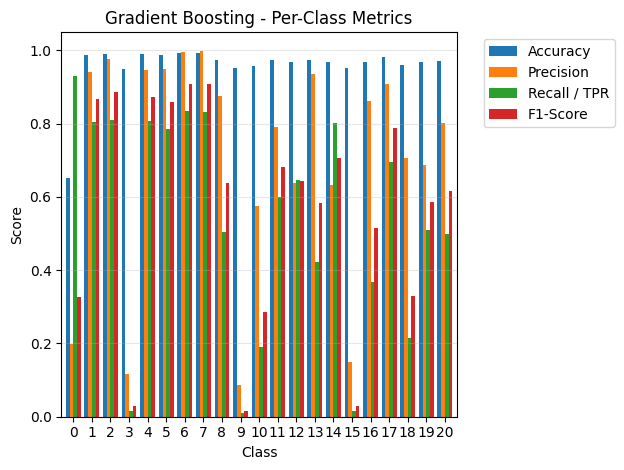

Data saved: output/1.00/data/Classification/per_class_analysis/svm_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_svm_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_svm_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

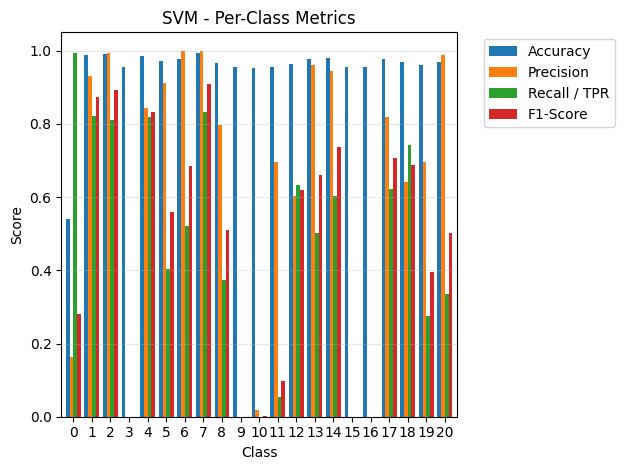

Data saved: output/1.00/data/Classification/per_class_analysis/k-nearest_neighbors_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_k-nearest_neighbors_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_k-nearest_neighbors_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

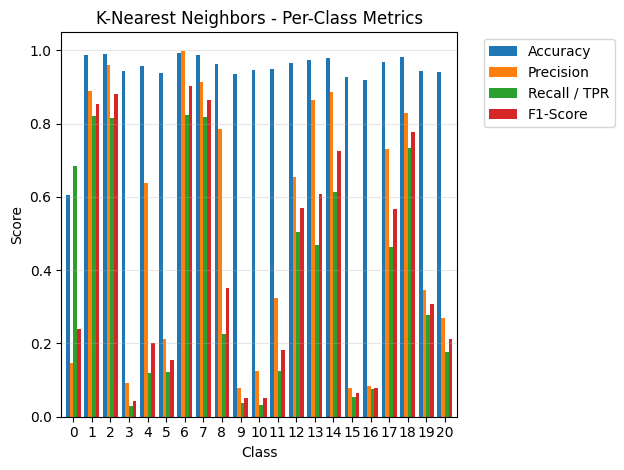

Data saved: output/1.00/data/Classification/per_class_analysis/ensemble_(voting)_detailed_metrics_classification_v1.00_.csv
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_ensemble_(voting)_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_metrics_ensemble_(voting)_v1.00_.png


<Figure size 1200x2500 with 0 Axes>

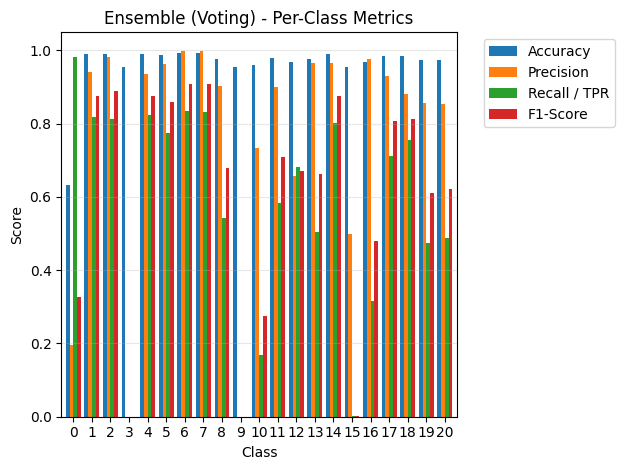

In [26]:
def plot_per_class_metrics(classification_results_per_model):
    """Plot per-class metrics comparison."""
    for model_name, df in classification_results_per_model.items():
        # Add average row
        average_row = df.mean(axis=0).to_frame().T
        average_row.index = ["Average"]
        df_with_avg = pd.concat([df, average_row])
        
        # Save detailed metrics
        save_dataframe(df_with_avg, f"{model_name.lower().replace(' ', '_')}_detailed_metrics", "classification")
        
        # Plot key metrics
        key_metrics = ["Accuracy", "Precision", "Recall / TPR", "F1-Score"]
        df_plot = df[key_metrics]
        
        plt.figure(figsize=(12, 25))
        df_plot.plot(kind="bar", width=0.8)
        plt.title(f"{model_name} - Per-Class Metrics")
        plt.xlabel("Class")
        plt.ylabel("Score")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.grid(axis="y", alpha=0.3)
        plt.xticks(rotation=0)
        plt.tight_layout()
        safe_name = model_name.lower().replace(" ", "_")
        save_plot(f"per_class_metrics_{safe_name}")
        plt.show()

plot_per_class_metrics(classification_results_per_model)

Plot saved: output/1.00/data/Classification/plots/detection_analysis/detection_delay_comparison_v1.00_.png


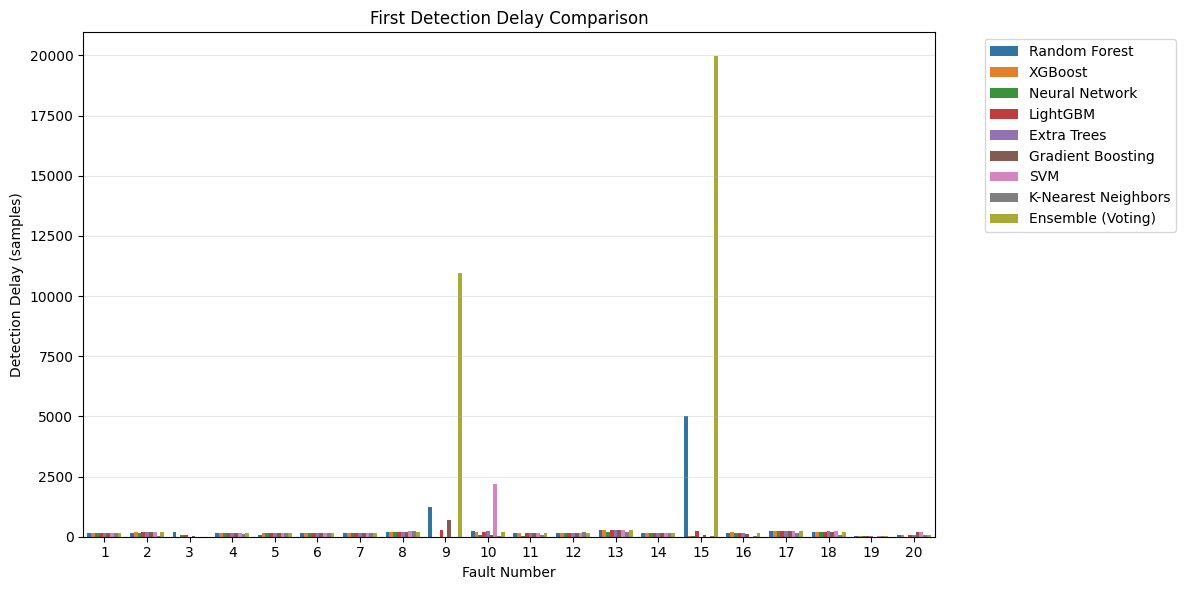

Data saved: output/1.00/data/Classification/detection_analysis/detection_delay_comparison_classification_v1.00_.csv


In [27]:
def plot_detection_delay_comparison(delay_tables_dict):
    """Plot first detection delay comparison."""
    combined_df = pd.concat(
        [df.assign(Model=model) for model, df in delay_tables_dict.items()],
        ignore_index=True,
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(data=combined_df, x="Fault", y="First Detection Delay", hue="Model")
    plt.title("First Detection Delay Comparison")
    plt.xlabel("Fault Number")
    plt.ylabel("Detection Delay (samples)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    save_plot("detection_delay_comparison")
    plt.show()
    
    # Save combined delay data
    save_dataframe(combined_df, "detection_delay_comparison", "classification")

plot_detection_delay_comparison(delay_tables_dict)

## Export Results Summary

## Comprehensive Per-Class Analysis and Comparison

In [28]:
print("=== COMPREHENSIVE PER-CLASS ANALYSIS ===")
print("Consolidating per-class results for all models...")

# Get all model predictions
model_predictions = {
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xg,
    'Neural Network': y_pred_nn,
    'LightGBM': y_pred_lgb,
    'Extra Trees': y_pred_et,
    'Gradient Boosting': y_pred_gb,
    'SVM': y_pred_svm
}

# Add ensemble if available
if 'y_pred_ensemble' in globals():
    model_predictions['Ensemble (Voting)'] = y_pred_ensemble

# Get unique classes and class names
unique_classes = sorted(np.unique(Y_TEST_REDUCED_DF))
class_names = [f"Class_{cls}" for cls in unique_classes]

print(f"✓ Models to analyze: {len(model_predictions)}")
print(f"✓ Classes to analyze: {len(unique_classes)} classes")
print(f"✓ Class range: {min(unique_classes)} to {max(unique_classes)}")

# Consolidate all per-class metrics
consolidated_metrics = {}
for model_name, y_pred in model_predictions.items():
    if model_name in classification_results_per_model:
        consolidated_metrics[model_name] = classification_results_per_model[model_name]
    else:
        # Calculate if missing
        consolidated_metrics[model_name] = compute_classification_metrics_per_class(Y_TEST_REDUCED_DF, y_pred)

print(f"✓ Consolidated metrics for {len(consolidated_metrics)} models")

=== COMPREHENSIVE PER-CLASS ANALYSIS ===
Consolidating per-class results for all models...
✓ Models to analyze: 8
✓ Classes to analyze: 21 classes
✓ Class range: 0 to 20
✓ Consolidated metrics for 8 models


In [29]:
# Create comprehensive per-class comparison DataFrames
metrics_list = ['Accuracy', 'Precision', 'Recall / TPR', 'F1-Score', 'FPR']

# Initialize comparison DataFrames for each metric
per_class_comparisons = {}
for metric in metrics_list:
    comparison_data = {}
    for model_name, df in consolidated_metrics.items():
        comparison_data[model_name] = df[metric].values
    
    per_class_comparisons[metric] = pd.DataFrame(
        comparison_data, 
        index=[f"Class_{cls}" for cls in unique_classes]
    )

# Display summary statistics for each metric
print("\n=== PER-CLASS PERFORMANCE SUMMARY ===")
for metric in metrics_list:
    df = per_class_comparisons[metric]
    print(f"\n{metric} Statistics:")
    print(f"Best performing model (mean): {df.mean().idxmax()} ({df.mean().max():.3f})")
    print(f"Most consistent model (std): {df.std().idxmin()} (±{df.std().min():.3f})")
    print(f"Best class overall: {df.max(axis=1).idxmax()} ({df.max(axis=1).max():.3f})")
    print(f"Most challenging class: {df.mean(axis=1).idxmin()} ({df.mean(axis=1).min():.3f})")

# Export per-class comparison tables
print(f"\n=== EXPORTING PER-CLASS COMPARISON DATA ===")
for metric in metrics_list:
    df = per_class_comparisons[metric].copy()  # Create a copy to avoid modifying original
    
    # Get only numeric columns for statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Add statistics columns
    df['Best_Model'] = df[numeric_cols].idxmax(axis=1)
    df['Best_Score'] = df[numeric_cols].max(axis=1)
    df['Worst_Model'] = df[numeric_cols].idxmin(axis=1)
    df['Worst_Score'] = df[numeric_cols].min(axis=1)
    df['Mean_Score'] = df[numeric_cols].mean(axis=1)
    df['Std_Score'] = df[numeric_cols].std(axis=1)
    
    # Save detailed comparison
    save_dataframe(df, f"per_class_comparison_{metric.lower().replace(' / ', '_').replace(' ', '_')}", "classification")

print("✓ Per-class comparison tables exported")


=== PER-CLASS PERFORMANCE SUMMARY ===

Accuracy Statistics:
Best performing model (mean): Ensemble (Voting) (0.961)
Most consistent model (std): Neural Network (±0.059)
Best class overall: Class_6 (0.992)
Most challenging class: Class_0 (0.628)

Precision Statistics:
Best performing model (mean): Ensemble (Voting) (0.769)
Most consistent model (std): Neural Network (±0.306)
Best class overall: Class_6 (1.000)
Most challenging class: Class_9 (0.066)

Recall / TPR Statistics:
Best performing model (mean): Neural Network (0.569)
Most consistent model (std): Neural Network (±0.290)
Best class overall: Class_0 (0.993)
Most challenging class: Class_15 (0.005)

F1-Score Statistics:
Best performing model (mean): Ensemble (Voting) (0.612)
Most consistent model (std): Gradient Boosting (±0.298)
Best class overall: Class_6 (0.909)
Most challenging class: Class_15 (0.009)

FPR Statistics:
Best performing model (mean): SVM (0.028)
Most consistent model (std): Neural Network (±0.064)
Best class ove


=== GENERATING PER-CLASS VISUALIZATIONS ===
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_performance_heatmaps_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_performance_heatmaps_v1.00_.png


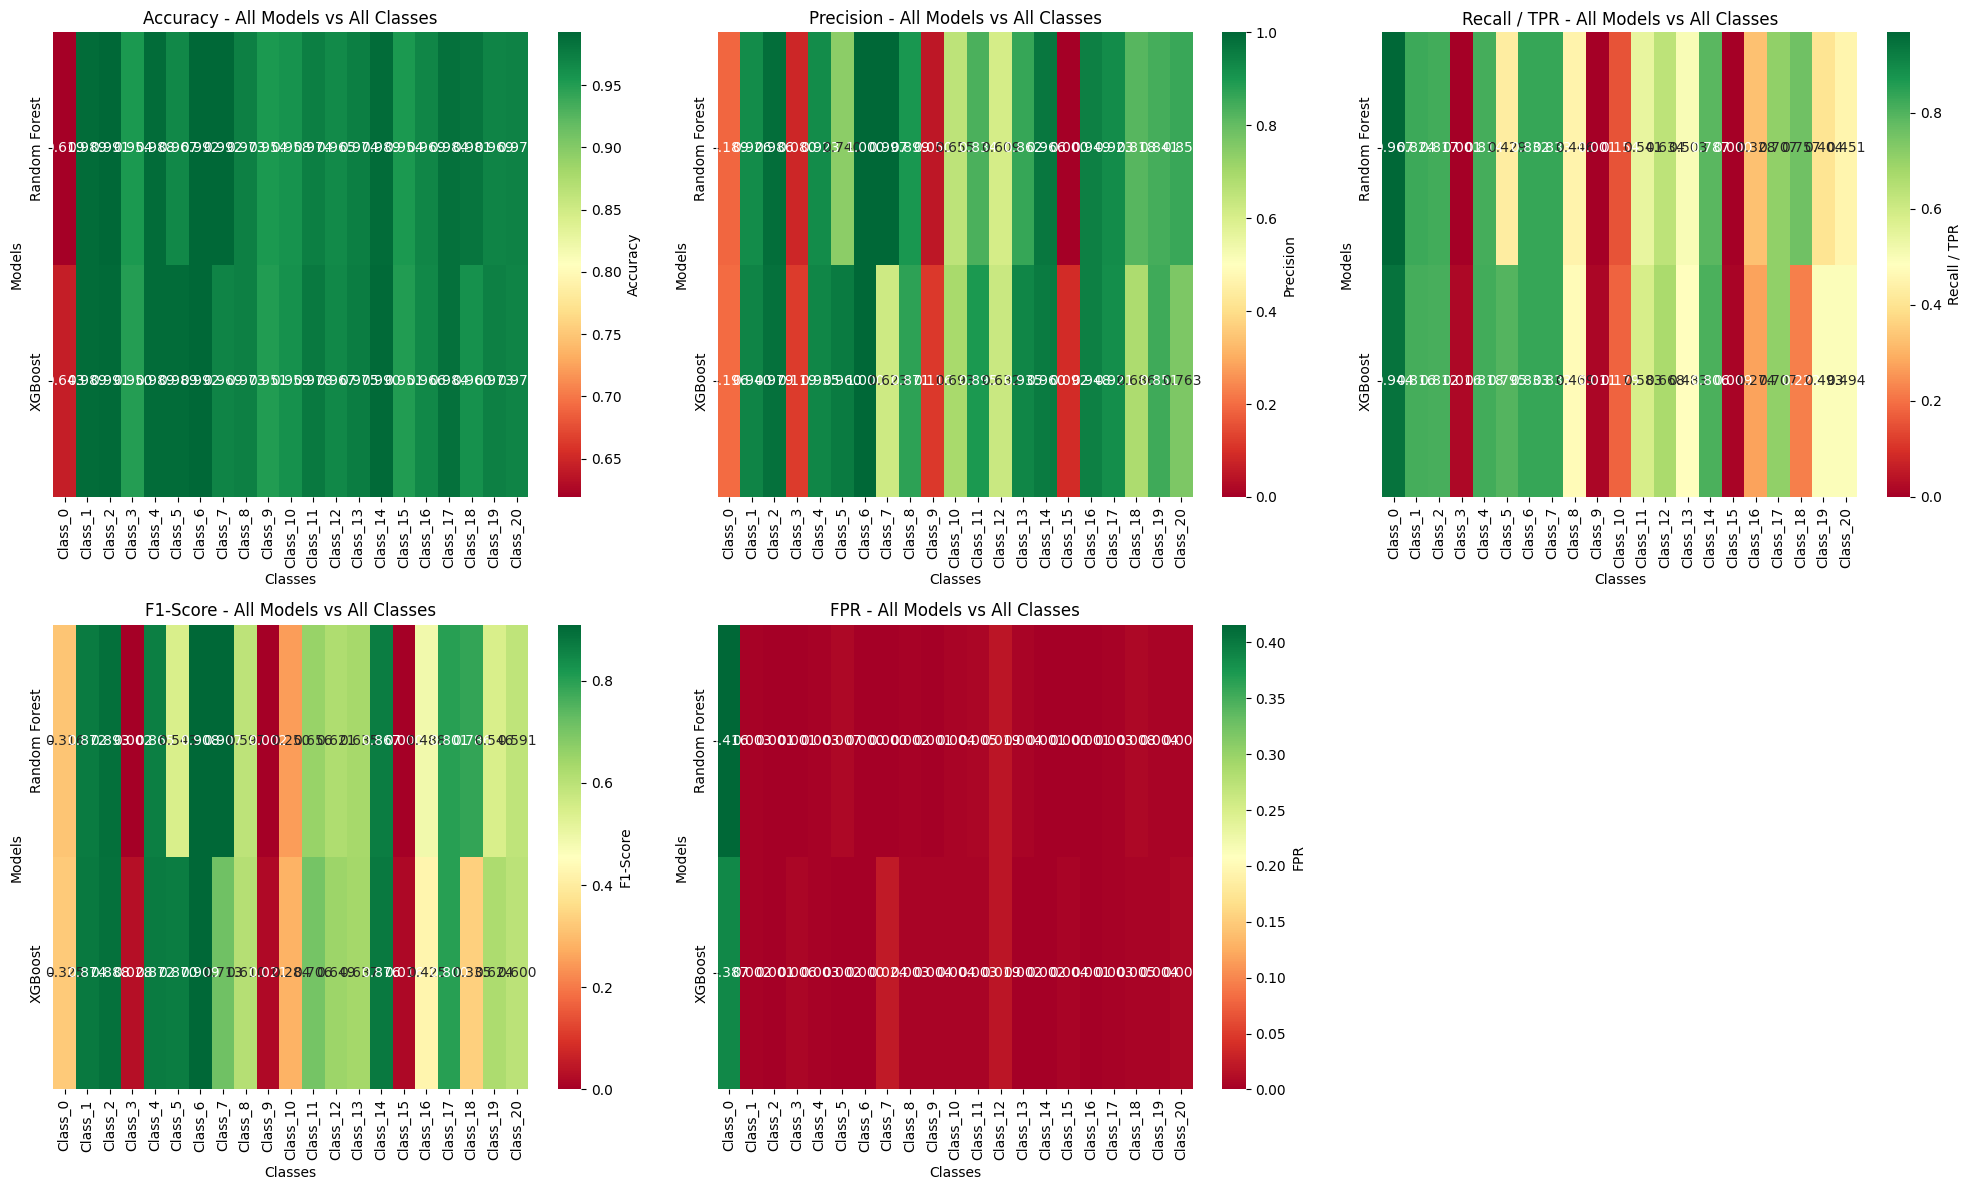

Plot saved: output/1.00/data/Classification/plots/per_class_analysis/per_class_radar_charts_v1.00_.png


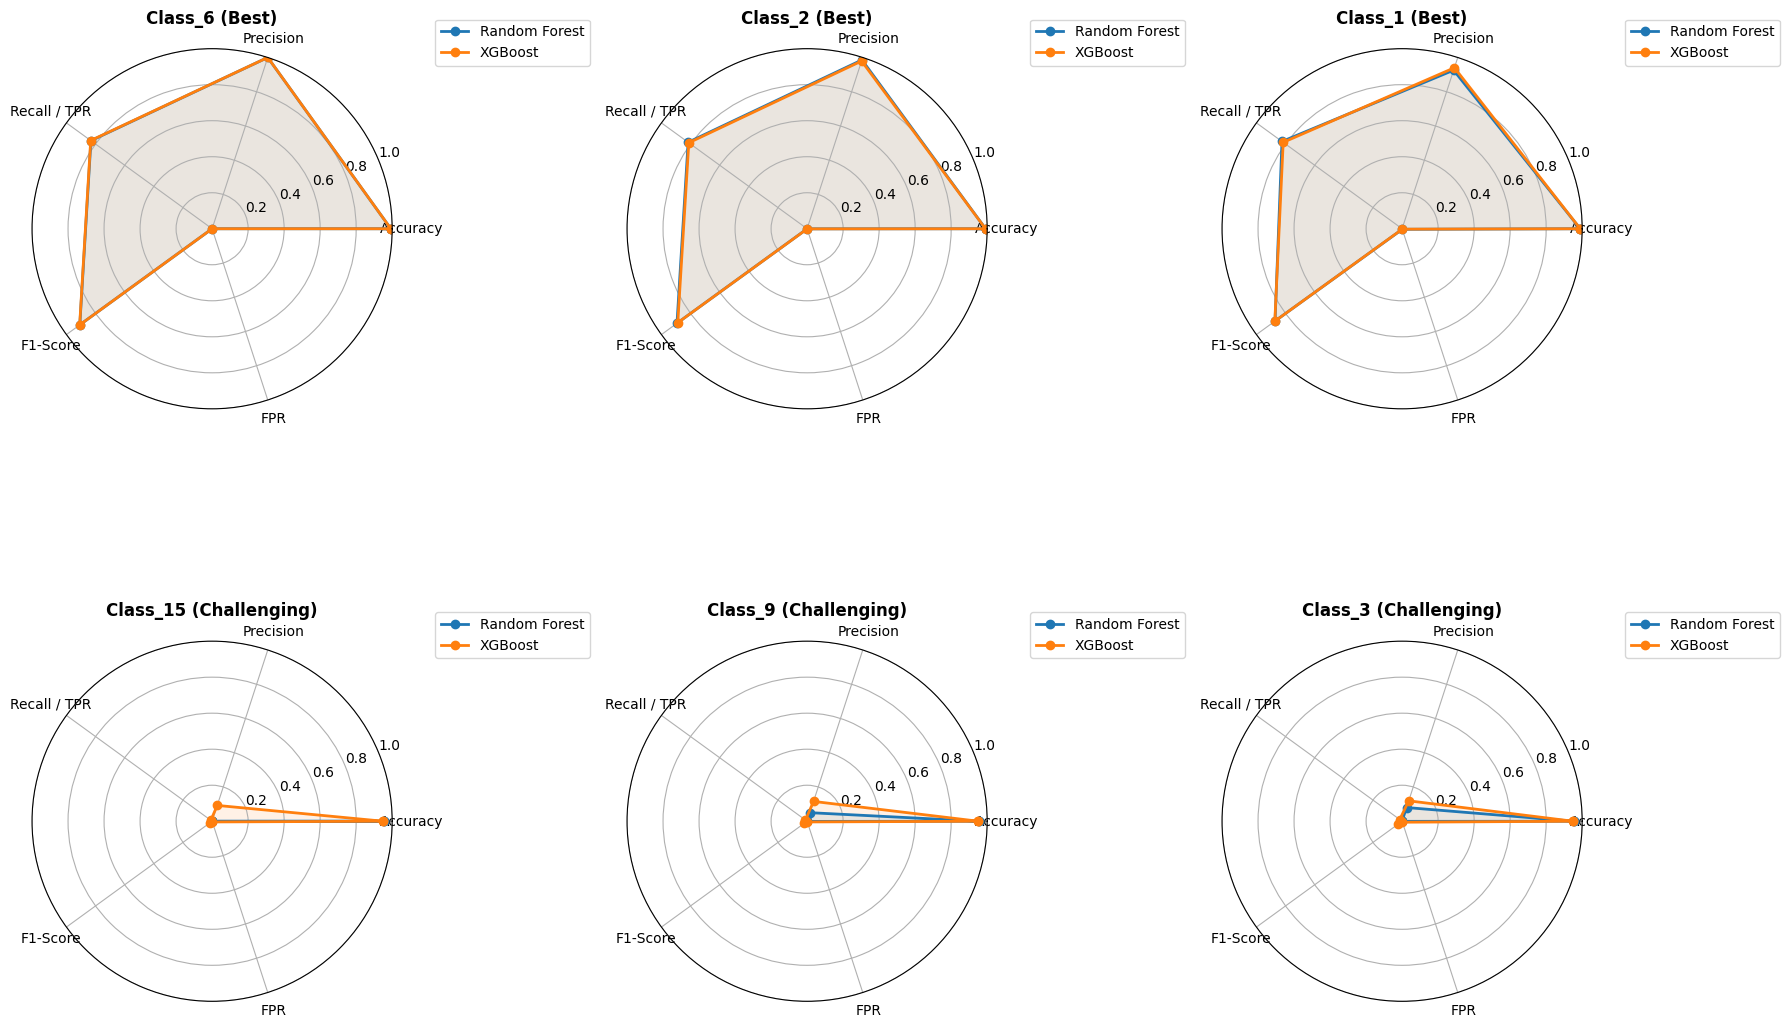

Plot saved: output/1.00/data/Classification/plots/model_comparison/class_difficulty_ranking_v1.00_.png


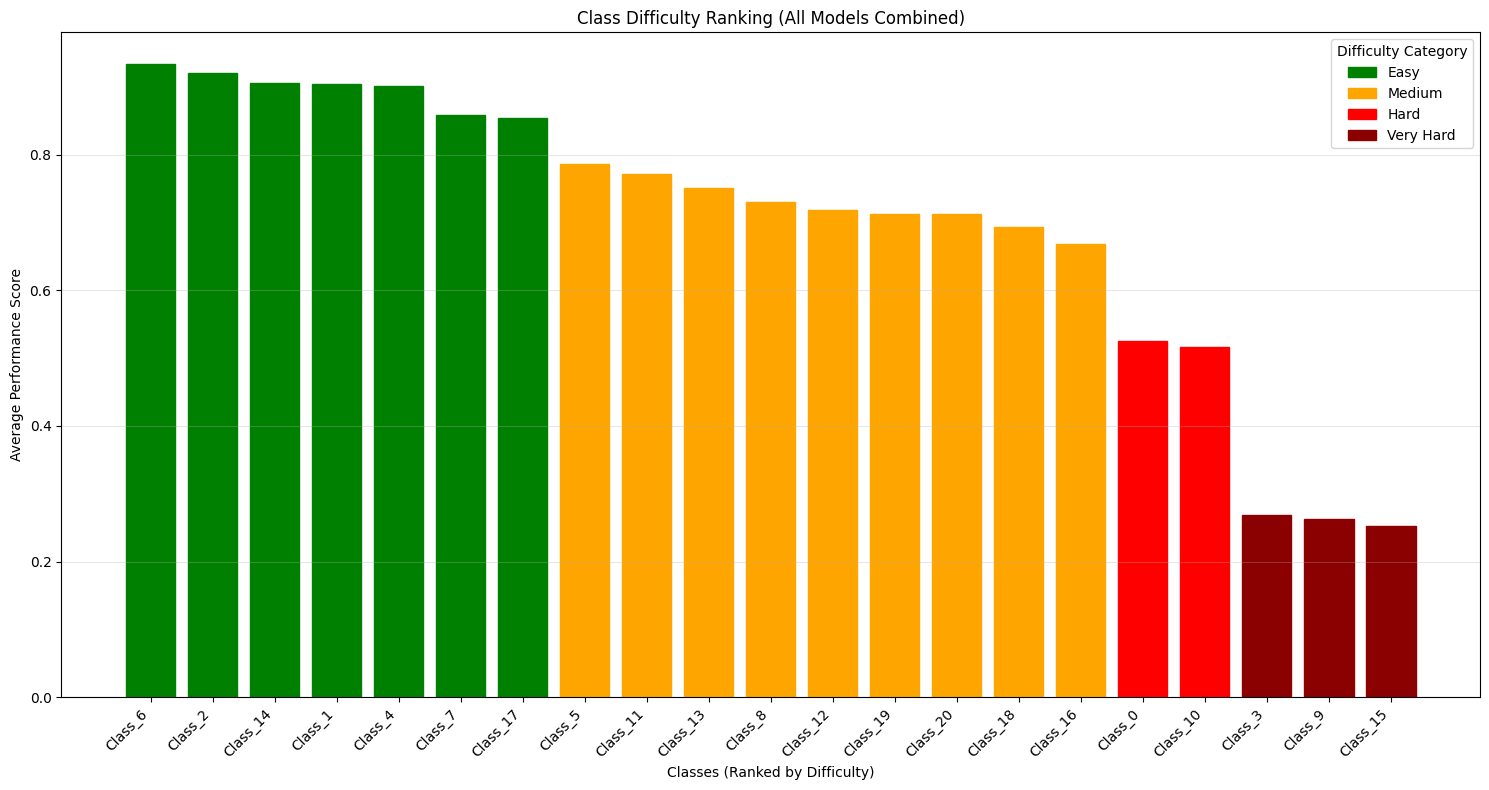

Data saved: output/1.00/data/Classification/per_class_analysis/class_difficulty_ranking_classification_v1.00_.csv

=== CLASS DIFFICULTY ANALYSIS ===
Easiest classes (Top 3):
  Class_6: 0.933 (Easy)
  Class_2: 0.920 (Easy)
  Class_14: 0.905 (Easy)

Most challenging classes (Bottom 3):
  Class_3: 0.269 (Very Hard)
  Class_9: 0.263 (Very Hard)
  Class_15: 0.253 (Very Hard)


In [30]:
def create_per_class_heatmaps():
    """Create heatmaps for each metric showing model vs class performance."""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics_list):
        if i < len(axes):
            df = per_class_comparisons[metric].iloc[:, :-6]  # Exclude statistics columns
            
            sns.heatmap(df.T, annot=True, fmt='.3f', cmap='RdYlGn', 
                       ax=axes[i], cbar_kws={'label': metric})
            axes[i].set_title(f'{metric} - All Models vs All Classes')
            axes[i].set_xlabel('Classes')
            axes[i].set_ylabel('Models')
    
    # Hide unused subplot
    if len(metrics_list) < len(axes):
        axes[-1].set_visible(False)
    
    plt.tight_layout()
    save_plot('per_class_performance_heatmaps')
    plt.show()

def create_per_class_radar_charts():
    """Create radar charts for top performing classes and models."""
    # Select top 3 best and worst performing classes based on F1-Score
    f1_df = per_class_comparisons['F1-Score']
    f1_means = f1_df.iloc[:, :-6].mean(axis=1)  # Exclude statistics columns
    
    best_classes = f1_means.nlargest(3).index.tolist()
    worst_classes = f1_means.nsmallest(3).index.tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
    
    # Plot best performing classes
    for i, class_name in enumerate(best_classes):
        ax = axes[0, i]
        
        # Get metrics for this class across all models
        angles = np.linspace(0, 2 * np.pi, len(metrics_list), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))
        
        for model in f1_df.columns[:-6]:  # Exclude statistics columns
            values = []
            for metric in metrics_list:
                class_idx = per_class_comparisons[metric].index.get_loc(class_name)
                values.append(per_class_comparisons[metric].iloc[class_idx][model])
            values += [values[0]]  # Complete the circle
            
            ax.plot(angles, values, 'o-', linewidth=2, label=model)
            ax.fill(angles, values, alpha=0.1)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics_list)
        ax.set_title(f'{class_name} (Best)', size=12, weight='bold')
        ax.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left')
        ax.set_ylim(0, 1)
    
    # Plot worst performing classes
    for i, class_name in enumerate(worst_classes):
        ax = axes[1, i]
        
        # Get metrics for this class across all models
        for model in f1_df.columns[:-6]:  # Exclude statistics columns
            values = []
            for metric in metrics_list:
                class_idx = per_class_comparisons[metric].index.get_loc(class_name)
                values.append(per_class_comparisons[metric].iloc[class_idx][model])
            values += [values[0]]  # Complete the circle
            
            ax.plot(angles, values, 'o-', linewidth=2, label=model)
            ax.fill(angles, values, alpha=0.1)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics_list)
        ax.set_title(f'{class_name} (Challenging)', size=12, weight='bold')
        ax.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left')
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    save_plot('per_class_radar_charts')
    plt.show()

def create_class_difficulty_ranking():
    """Create ranking of classes by difficulty across all models."""
    # Calculate mean performance across all metrics and models for each class
    class_difficulty = {}
    
    for class_name in unique_classes:
        class_idx = f"Class_{class_name}"
        total_performance = 0
        metric_count = 0
        
        for metric in ['Accuracy', 'Precision', 'Recall / TPR', 'F1-Score']:  # Exclude FPR as lower is better
            df = per_class_comparisons[metric]
            class_performance = df.loc[class_idx].iloc[:-6].mean()  # Exclude statistics columns
            total_performance += class_performance
            metric_count += 1
        
        class_difficulty[class_idx] = total_performance / metric_count
    
    # Create ranking DataFrame
    difficulty_df = pd.DataFrame(list(class_difficulty.items()), 
                                columns=['Class', 'Average_Performance'])
    difficulty_df = difficulty_df.sort_values('Average_Performance', ascending=False)
    difficulty_df['Difficulty_Rank'] = range(1, len(difficulty_df) + 1)
    difficulty_df['Category'] = pd.cut(difficulty_df['Average_Performance'], 
                                      bins=[0, 0.4, 0.6, 0.8, 1.0], 
                                      labels=['Very Hard', 'Hard', 'Medium', 'Easy'])
    
    # Visualize class difficulty
    plt.figure(figsize=(15, 8))
    colors = {'Easy': 'green', 'Medium': 'orange', 'Hard': 'red', 'Very Hard': 'darkred'}
    
    bars = plt.bar(range(len(difficulty_df)), difficulty_df['Average_Performance'])
    for i, (_, row) in enumerate(difficulty_df.iterrows()):
        bars[i].set_color(colors[row['Category']])
    
    plt.xlabel('Classes (Ranked by Difficulty)')
    plt.ylabel('Average Performance Score')
    plt.title('Class Difficulty Ranking (All Models Combined)')
    plt.xticks(range(len(difficulty_df)), difficulty_df['Class'], rotation=45, ha='right')
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, color=colors[cat], label=cat) 
                      for cat in ['Easy', 'Medium', 'Hard', 'Very Hard']]
    plt.legend(handles=legend_elements, title='Difficulty Category')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    save_plot('class_difficulty_ranking')
    plt.show()
    
    # Export ranking
    save_dataframe(difficulty_df, "class_difficulty_ranking", "classification")
    
    print("\n=== CLASS DIFFICULTY ANALYSIS ===")
    print(f"Easiest classes (Top 3):")
    for _, row in difficulty_df.head(3).iterrows():
        print(f"  {row['Class']}: {row['Average_Performance']:.3f} ({row['Category']})")
    
    print(f"\nMost challenging classes (Bottom 3):")
    for _, row in difficulty_df.tail(3).iterrows():
        print(f"  {row['Class']}: {row['Average_Performance']:.3f} ({row['Category']})")
    
    return difficulty_df

# Generate all visualizations
print("\n=== GENERATING PER-CLASS VISUALIZATIONS ===")
create_per_class_heatmaps()
create_per_class_radar_charts()
difficulty_ranking = create_class_difficulty_ranking()


=== MODEL SPECIALIZATION ANALYSIS ===
Plot saved: output/1.00/data/Classification/plots/model_comparison/model_specialization_analysis_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/model_comparison/model_specialization_analysis_v1.00_.png


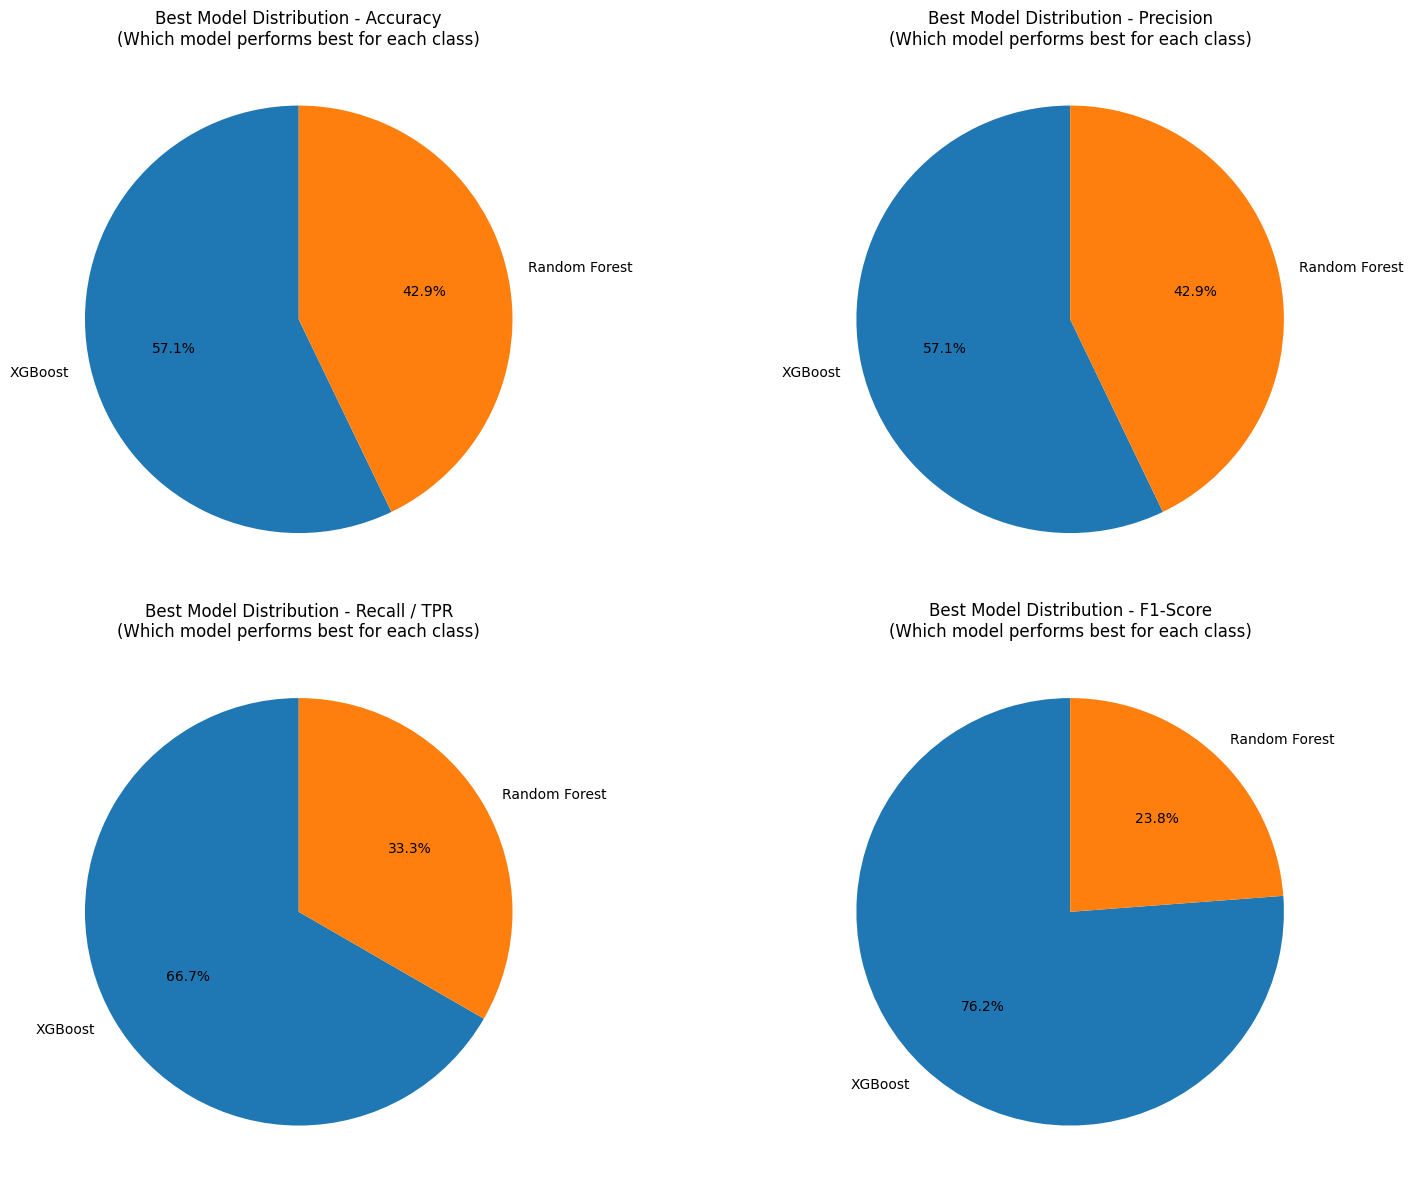

Data saved: output/1.00/data/Classification/per_class_analysis/model_specialization_per_class_classification_v1.00_.csv
Model Specialization Summary:

Accuracy:
  Most specialized: XGBoost (best for 12/21 classes)
  XGBoost: 12 classes (57.1%)
  Random Forest: 9 classes (42.9%)

Precision:
  Most specialized: XGBoost (best for 12/21 classes)
  XGBoost: 12 classes (57.1%)
  Random Forest: 9 classes (42.9%)

Recall / TPR:
  Most specialized: XGBoost (best for 14/21 classes)
  XGBoost: 14 classes (66.7%)
  Random Forest: 7 classes (33.3%)

F1-Score:
  Most specialized: XGBoost (best for 16/21 classes)
  XGBoost: 16 classes (76.2%)
  Random Forest: 5 classes (23.8%)
Plot saved: output/1.00/data/Classification/plots/confusion_matrices/confusion_matrices_comparison_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/confusion_matrices/confusion_matrices_comparison_v1.00_.png


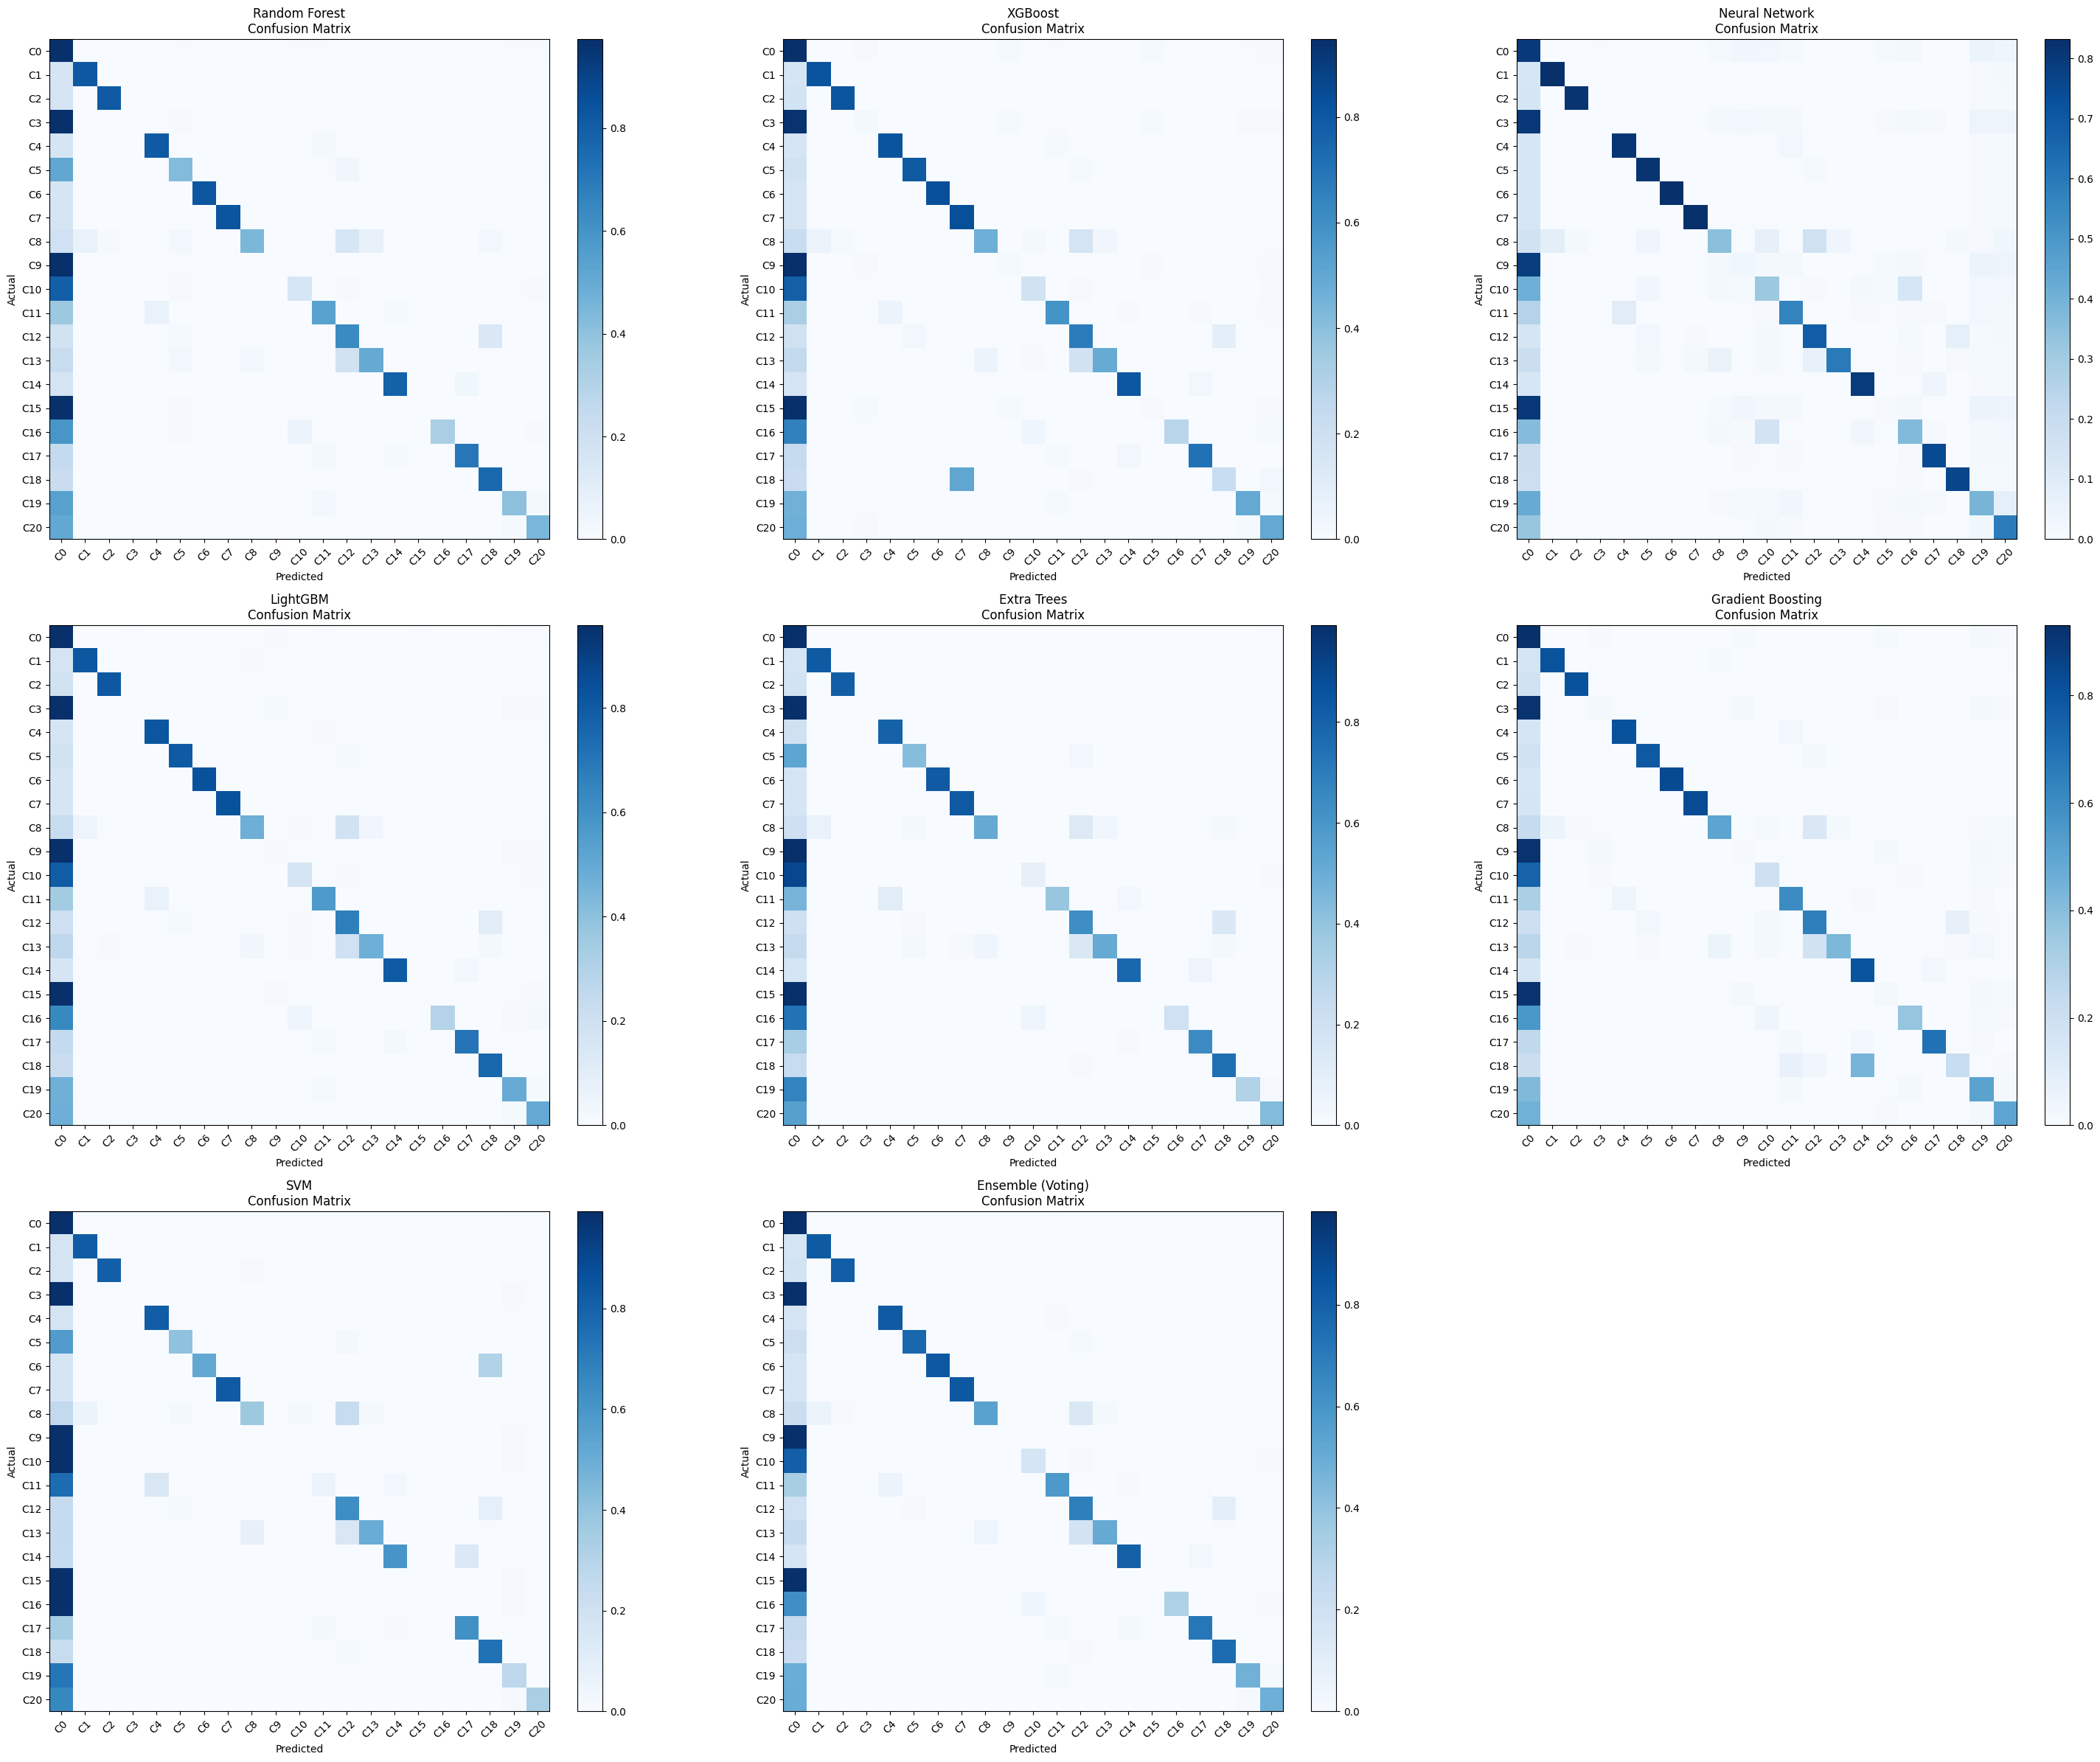


=== CLASS-WISE MODEL RANKING ===
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/best_models_per_class_count_v1.00_.png
Plot saved: output/1.00/data/Classification/plots/per_class_analysis/best_models_per_class_count_v1.00_.png


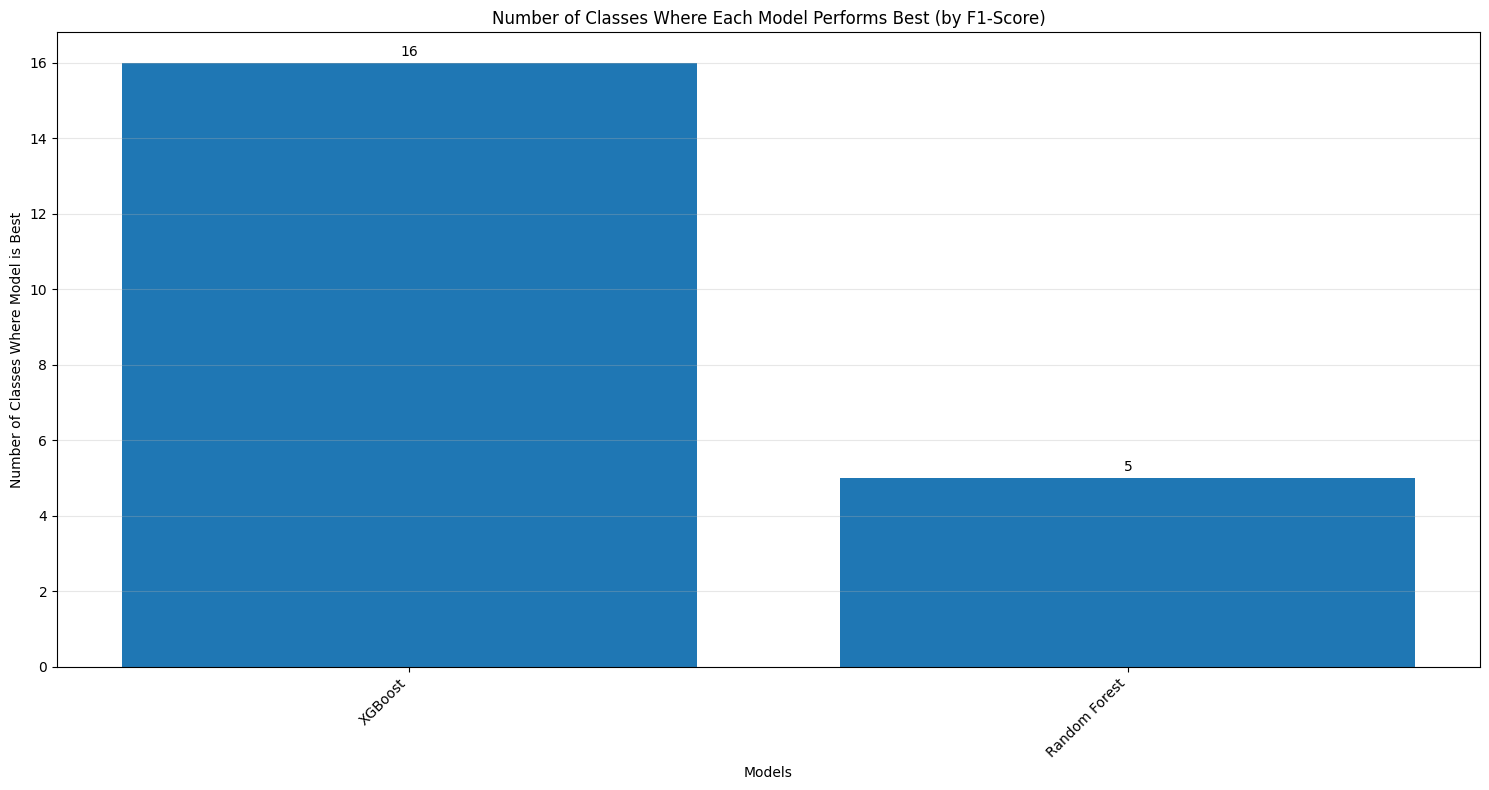

Data saved: output/1.00/data/Classification/per_class_analysis/class_wise_model_rankings_classification_v1.00_.csv
Classes with largest performance gaps between best and worst models:
  Class_18: 0.451 gap (Random Forest vs XGBoost)
  Class_5: 0.326 gap (XGBoost vs Random Forest)
  Class_7: 0.195 gap (Random Forest vs XGBoost)

Most consistent classes (smallest performance gaps):
  Class_17: 0.001 gap (all models perform similarly)
  Class_6: 0.001 gap (all models perform similarly)
  Class_1: 0.002 gap (all models perform similarly)


In [31]:
def create_model_specialization_analysis():
    """Analyze which models perform best for which classes."""
    print("\n=== MODEL SPECIALIZATION ANALYSIS ===")
    
    # For each class, find the best performing model for each metric
    model_specialization = {}
    
    for metric in ['Accuracy', 'Precision', 'Recall / TPR', 'F1-Score']:
        df = per_class_comparisons[metric]
        best_models = df.iloc[:, :-6].idxmax(axis=1)  # Exclude statistics columns
        model_specialization[metric] = best_models
    
    # Create specialization summary
    specialization_df = pd.DataFrame(model_specialization)
    
    # Count how many times each model is the best for each metric
    model_wins = {}
    for metric in specialization_df.columns:
        wins = specialization_df[metric].value_counts()
        model_wins[metric] = wins
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(['Accuracy', 'Precision', 'Recall / TPR', 'F1-Score']):
        wins = specialization_df[metric].value_counts()
        
        # Create pie chart
        axes[i].pie(wins.values, labels=wins.index, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Best Model Distribution - {metric}\n(Which model performs best for each class)')
    
    plt.tight_layout()
    save_plot('model_specialization_analysis')
    plt.show()
    
    # Export specialization data
    save_dataframe(specialization_df, "model_specialization_per_class", "classification")
    
    # Print summary
    print("Model Specialization Summary:")
    for metric in ['Accuracy', 'Precision', 'Recall / TPR', 'F1-Score']:
        wins = specialization_df[metric].value_counts()
        best_model = wins.idxmax()
        print(f"\n{metric}:")
        print(f"  Most specialized: {best_model} (best for {wins.max()}/{len(unique_classes)} classes)")
        for model, count in wins.head(3).items():
            print(f"  {model}: {count} classes ({count/len(unique_classes)*100:.1f}%)")

def create_confusion_matrix_comparison():
    """Create side-by-side confusion matrices for all models."""
    n_models = len(model_predictions)
    cols = 3
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols*2, 4*rows*2))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (model_name, y_pred) in enumerate(model_predictions.items()):
        row, col = divmod(i, cols)
        
        cm = confusion_matrix(Y_TEST_REDUCED_DF, y_pred, normalize='true')
        
        im = axes[row, col].imshow(cm, interpolation='nearest', cmap='Blues')
        axes[row, col].set_title(f'{model_name}\nConfusion Matrix')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)
        
        # Add labels
        tick_marks = np.arange(len(unique_classes))
        axes[row, col].set_xticks(tick_marks)
        axes[row, col].set_yticks(tick_marks)
        axes[row, col].set_xticklabels([f'C{c}' for c in unique_classes], rotation=45)
        axes[row, col].set_yticklabels([f'C{c}' for c in unique_classes])
        axes[row, col].set_xlabel('Predicted')
        axes[row, col].set_ylabel('Actual')
    
    # Hide unused subplots
    for i in range(len(model_predictions), rows * cols):
        row, col = divmod(i, cols)
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    save_plot('confusion_matrices_comparison')
    plt.show()

def create_class_wise_model_ranking():
    """Create ranking of models for each class."""
    print("\n=== CLASS-WISE MODEL RANKING ===")
    
    # For each class, rank models by F1-Score
    f1_df = per_class_comparisons['F1-Score'].iloc[:, :-6]  # Exclude statistics columns
    
    class_rankings = {}
    for class_name in f1_df.index:
        # Convert to numeric and sort
        class_scores = pd.to_numeric(f1_df.loc[class_name], errors='coerce').sort_values(ascending=False)
        # Remove any NaN values
        class_scores = class_scores.dropna()
        
        if len(class_scores) > 0:
            class_rankings[class_name] = {
                'Best': class_scores.index[0],
                'Best_Score': float(class_scores.iloc[0]),
                'Worst': class_scores.index[-1],
                'Worst_Score': float(class_scores.iloc[-1]),
                'Score_Range': float(class_scores.iloc[0] - class_scores.iloc[-1]),
                'Full_Ranking': list(class_scores.index)
            }
    
    # Create summary DataFrame
    ranking_summary = pd.DataFrame(class_rankings).T
    
    # Ensure Score_Range is numeric
    ranking_summary['Score_Range'] = pd.to_numeric(ranking_summary['Score_Range'], errors='coerce')
    
    # Visualize best models per class
    plt.figure(figsize=(15, 8))
    best_models = ranking_summary['Best'].value_counts()
    
    bars = plt.bar(range(len(best_models)), best_models.values)
    plt.xlabel('Models')
    plt.ylabel('Number of Classes Where Model is Best')
    plt.title('Number of Classes Where Each Model Performs Best (by F1-Score)')
    plt.xticks(range(len(best_models)), best_models.index, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, best_models.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                str(value), ha='center', va='bottom')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    save_plot('best_models_per_class_count')
    plt.show()
    
    # Export detailed rankings
    save_dataframe(ranking_summary, "class_wise_model_rankings", "classification")
    
    # Print top insights - handle potential missing Score_Range values
    score_range_numeric = pd.to_numeric(ranking_summary['Score_Range'], errors='coerce')
    if not score_range_numeric.isna().all():
        print(f"Classes with largest performance gaps between best and worst models:")
        top_gaps = ranking_summary.loc[score_range_numeric.nlargest(3).index]
        for class_name, row in top_gaps.iterrows():
            score_range = pd.to_numeric(row['Score_Range'], errors='coerce')
            if not pd.isna(score_range):
                print(f"  {class_name}: {score_range:.3f} gap ({row['Best']} vs {row['Worst']})")
        
        print(f"\nMost consistent classes (smallest performance gaps):")
        bottom_gaps = ranking_summary.loc[score_range_numeric.nsmallest(3).index]
        for class_name, row in bottom_gaps.iterrows():
            score_range = pd.to_numeric(row['Score_Range'], errors='coerce')
            if not pd.isna(score_range):
                print(f"  {class_name}: {score_range:.3f} gap (all models perform similarly)")
    else:
        print("Unable to calculate performance gaps due to data type issues.")

# Execute all analysis functions
create_model_specialization_analysis()
create_confusion_matrix_comparison() 
create_class_wise_model_ranking()

In [32]:
def verify_random_seeds():
    """Verify that all models use consistent random seeds."""
    print("\n=== RANDOM SEED VERIFICATION ===")
    
    seed_info = {
        'Random Forest': 42,
        'XGBoost': 42, 
        'Extra Trees': 42,
        'Gradient Boosting': 42,
        'SVM': 42,
        'LightGBM': 42,  # via params dict
        'Neural Network': 'Not set (keras default)',
        'Ensemble (Voting)': 42,  # individual models have seeds
        'KNN': 'No random seed (deterministic)',
        'Cross-validation': 42,  # StratifiedKFold
        'Data splitting': 'No random split (deterministic indexing)'
    }
    
    print("Random seed configuration across all methods:")
    consistent_seed = 42
    inconsistent_methods = []
    
    for method, seed in seed_info.items():
        if isinstance(seed, int) and seed == consistent_seed:
            status = "✓ Consistent"
        elif method in ['KNN', 'Data splitting']:
            status = "✓ Deterministic"
        else:
            status = "⚠ Different/Not set"
            inconsistent_methods.append(method)
        
        print(f"  {method:<20}: {str(seed):<25} {status}")
    
    if inconsistent_methods:
        print(f"\n⚠ Warning: {len(inconsistent_methods)} methods may have different randomization:")
        for method in inconsistent_methods:
            print(f"  - {method}")
        print("\nRecommendation: Set consistent random seeds for reproducible results")
    else:
        print(f"\n✓ All randomized methods use consistent seed ({consistent_seed}) or are deterministic")
    
    return seed_info

def export_comprehensive_results_summary():
    """Export a comprehensive summary of all results."""
    print("\n=== COMPREHENSIVE RESULTS EXPORT ===")
    
    # Create master summary dictionary
    export_summary = {
        'analysis_metadata': {
            'version': VERSION,
            'timestamp': datetime.now().isoformat(),
            'total_models': len(model_predictions),
            'total_classes': len(unique_classes),
            'test_samples': len(Y_TEST_REDUCED_DF),
            'feature_count': X_TRAIN.shape[1]
        },
        'model_list': list(model_predictions.keys()),
        'class_list': list(unique_classes) if hasattr(unique_classes, '__iter__') else unique_classes,
        'overall_best_model': models_results_list[0]['Model'],  # Use the list instead
        'overall_best_accuracy': max(result['Accuracy'] for result in models_results_list),
        'overall_best_f1': max(result['F1-Score'] for result in models_results_list),
        'random_seed_status': verify_random_seeds()
    }
    
    # Export master summary as JSON
    import json
    summary_path = os.path.join(OUTPUT_PATH, "data", f"comprehensive_analysis_summary_v{VERSION}_.json")
    with open(summary_path, 'w') as f:
        json.dump(export_summary, f, indent=2, default=str)
    
    # Create export checklist
    export_checklist = {
        'Overall Performance': [
            'model_results_average_classification_*.csv',
            'final_model_rankings_classification_*.csv',
            'cross_validation_results_v*.png'
        ],
        'Per-Class Analysis': [
            'per_class_comparison_accuracy_classification_*.csv',
            'per_class_comparison_precision_classification_*.csv', 
            'per_class_comparison_recall_tpr_classification_*.csv',
            'per_class_comparison_f1-score_classification_*.csv',
            'per_class_comparison_fpr_classification_*.csv',
            'model_specialization_per_class_classification_*.csv',
            'class_difficulty_ranking_classification_*.csv',
            'class_wise_model_rankings_classification_*.csv'
        ],
        'Visualizations': [
            'per_class_performance_heatmaps_v*.png',
            'per_class_radar_charts_v*.png', 
            'class_difficulty_ranking_v*.png',
            'model_specialization_analysis_v*.png',
            'confusion_matrices_comparison_v*.png',
            'best_models_per_class_count_v*.png',
            'comprehensive_model_comparison_v*.png'
        ],
        'Trained Models': [
            'model_random_forest_v*.pkl',
            'model_xgboost_v*.pkl',
            'model_neural_network_v*.pkl',
            'model_lightgbm_v*.pkl',
            'model_extra_trees_v*.pkl',
            'model_gradient_boosting_v*.pkl',
            'model_svm_v*.pkl'
        ],
        'Detection Analysis': [
            'detection_delay_comparison_classification_*.csv',
            'detection_delay_comparison_v*.png'
        ]
    }
    
    print(f"\n✓ Master summary exported: {summary_path}")
    print(f"\n=== EXPORT CHECKLIST ===")
    total_files = 0
    for category, files in export_checklist.items():
        print(f"\n{category}:")
        for file_pattern in files:
            print(f"  ✓ {file_pattern}")
            total_files += 1
    
    print(f"\n📊 ANALYSIS COMPLETE!")
    print(f"   • {len(model_predictions)} models analyzed")
    print(f"   • {len(unique_classes)} classes compared") 
    print(f"   • {total_files}+ files exported")
    print(f"   • Results saved to: output/data/ and output/{VERSION}/")
    
    return export_summary

# Execute verification and export
export_summary = export_comprehensive_results_summary()


=== COMPREHENSIVE RESULTS EXPORT ===

=== RANDOM SEED VERIFICATION ===
Random seed configuration across all methods:
  Random Forest       : 42                        ✓ Consistent
  XGBoost             : 42                        ✓ Consistent
  Extra Trees         : 42                        ✓ Consistent
  Gradient Boosting   : 42                        ✓ Consistent
  SVM                 : 42                        ✓ Consistent
  LightGBM            : 42                        ✓ Consistent
  Neural Network      : Not set (keras default)   ⚠ Different/Not set
  Ensemble (Voting)   : 42                        ✓ Consistent
  KNN                 : No random seed (deterministic) ✓ Deterministic
  Cross-validation    : 42                        ✓ Consistent
  Data splitting      : No random split (deterministic indexing) ✓ Deterministic

⚠ Warning: 1 methods may have different randomization:
  - Neural Network

Recommendation: Set consistent random seeds for reproducible results


FileNotFoundError: [Errno 2] No such file or directory: 'output/data/comprehensive_analysis_summary_v1.00_.json'

In [ ]:
# Create comprehensive results summary
results_summary = {
    'best_model': model_classification_average.loc[model_classification_average['Accuracy'].idxmax(), 'Model'],
    'best_accuracy': model_classification_average['Accuracy'].max(),
    'best_f1': model_classification_average['F1-Score'].max(),
    'models_trained': list(classification_results_per_model.keys()),
    'total_test_samples': len(Y_TEST_REDUCED_DF),
    'unique_classes': len(np.unique(Y_TEST_REDUCED_DF))
}

# Save results summary using the unified directory structure
import json
summary_dir = os.path.join(OUTPUT_PATH, "data", "Classification")
os.makedirs(summary_dir, exist_ok=True)
summary_path = os.path.join(summary_dir, f"classification_summary_v{VERSION}_.json")

with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print("\n=== Classification Analysis Complete ===")
print(f"Best performing model: {results_summary['best_model']}")
print(f"Best accuracy: {results_summary['best_accuracy']:.3f}")
print(f"Best F1-score: {results_summary['best_f1']:.3f}")
print(f"\nResults saved to: {summary_dir}/")
print("Files generated:")
print("- model_results_average_classification_*.csv")
print("- *_detailed_metrics_classification_*.csv (per model)")
print("- detection_delay_comparison_classification_*.csv")
print("- classification_summary_*.json")
print("- model_*.pkl (trained models)")
print("- Various plots in Classification/ subfolder")

In [ ]:
# Create Enhanced Per-Metric Visualizations
print("\n=== CREATING ENHANCED PER-METRIC VISUALIZATIONS ===")

# First, let's recreate the per-class comparison DataFrame for visualization
print("Recreating per-class metrics DataFrame...")

# Collect per-class metrics for all models
all_per_class_data = []

for model_name, results in classification_results_per_model.items():
    if 'classification_report_dict' in results:
        class_report = results['classification_report_dict']
        
        # Extract per-class metrics (excluding macro/micro/weighted averages)
        for class_label, metrics in class_report.items():
            if class_label not in ['accuracy', 'macro avg', 'micro avg', 'weighted avg'] and isinstance(metrics, dict):
                all_per_class_data.extend([
                    {
                        'Model': model_name,
                        'Class': class_label,
                        'Metric': 'Precision',
                        'Score': metrics.get('precision', 0)
                    },
                    {
                        'Model': model_name,
                        'Class': class_label,
                        'Metric': 'Recall',
                        'Score': metrics.get('recall', 0)
                    },
                    {
                        'Model': model_name,
                        'Class': class_label,
                        'Metric': 'F1-Score',
                        'Score': metrics.get('f1-score', 0)
                    }
                ])

# Create DataFrame
per_class_enhanced_df = pd.DataFrame(all_per_class_data)

if not per_class_enhanced_df.empty:
    # Convert Score to numeric, handling any errors
    per_class_enhanced_df['Score'] = pd.to_numeric(per_class_enhanced_df['Score'], errors='coerce')
    per_class_enhanced_df = per_class_enhanced_df.dropna(subset=['Score'])
    
    print(f"Per-class data shape: {per_class_enhanced_df.shape}")
    print(f"Available metrics: {per_class_enhanced_df['Metric'].unique()}")
    print(f"Available models: {per_class_enhanced_df['Model'].unique()}")
    
    # Create comprehensive per-metric visualizations
    create_comprehensive_per_metric_visualizations(per_class_enhanced_df, " (Enhanced)")
    
    # Save the enhanced data
    save_dataframe(per_class_enhanced_df, "per_class_enhanced_metrics", "all_models")
    
    print("✓ Enhanced per-metric visualizations completed!")
    print("✓ All plots organized into appropriate subfolders")
    print("✓ Enhanced data exported")
else:
    print("❌ No per-class data available for enhanced visualizations")

print("\n=== ENHANCED VISUALIZATION SUMMARY ===")
print("Created separate visualizations for each metric:")
print("  • F1-Score: heatmap, barplot, boxplot")
print("  • Precision: heatmap, barplot, boxplot") 
print("  • Recall: heatmap, barplot, boxplot")
print("\nAll plots saved with improved sizing and organization:")
print("  • Heatmaps: 16x10 inches")
print("  • Barplots: 18x10 inches") 
print("  • Boxplots: 14x8 inches")
print("\nOutput structure:")
print("  output/Classification/plots/per_class_analysis/")
print("    ├── per_class_f1-score_comparison.png")
print("    ├── per_class_f1-score_barplot.png")
print("    ├── f1-score_distribution_boxplot.png")
print("    ├── per_class_precision_comparison.png")
print("    ├── per_class_precision_barplot.png")
print("    ├── precision_distribution_boxplot.png")
print("    ├── per_class_recall_comparison.png")
print("    ├── per_class_recall_barplot.png")
print("    └── recall_distribution_boxplot.png")

In [ ]:
# Test and Create the Per-Metric Visualizations
print("=== TESTING PER-METRIC VISUALIZATIONS ===")

# Check if we have the per_class_enhanced_df from the previous cell
if 'per_class_enhanced_df' in locals() and not per_class_enhanced_df.empty:
    print(f"✓ Data available: {per_class_enhanced_df.shape}")
    print(f"✓ Metrics: {per_class_enhanced_df['Metric'].unique()}")
    print(f"✓ Models: {per_class_enhanced_df['Model'].unique()}")
    
    # Test the individual functions
    metrics = per_class_enhanced_df['Metric'].unique()
    for metric in metrics:
        print(f"\n--- Creating visualizations for {metric} ---")
        
        # Create heatmap comparison
        plot_per_class_metric_comparison(per_class_enhanced_df, metric, " (Test)")
        
        # Create bar plot comparison  
        plot_per_class_metric_barplot(per_class_enhanced_df, metric, " (Test)")
        
        # Create box plot for distribution
        plot_per_class_metric_boxplot(per_class_enhanced_df, metric, " (Test)")
        
        print(f"✓ Completed {metric} visualizations")
    
    print("\n✅ All per-metric visualizations completed!")
    
else:
    print("❌ per_class_enhanced_df not available - recreating...")
    
    # Recreate the per-class data
    all_per_class_data = []
    
    for model_name, results in classification_results_per_model.items():
        if 'classification_report_dict' in results:
            class_report = results['classification_report_dict']
            
            for class_label, metrics in class_report.items():
                if class_label not in ['accuracy', 'macro avg', 'micro avg', 'weighted avg'] and isinstance(metrics, dict):
                    all_per_class_data.extend([
                        {
                            'Model': model_name,
                            'Class': class_label,
                            'Metric': 'Precision',
                            'Score': metrics.get('precision', 0)
                        },
                        {
                            'Model': model_name,
                            'Class': class_label,
                            'Metric': 'Recall', 
                            'Score': metrics.get('recall', 0)
                        },
                        {
                            'Model': model_name,
                            'Class': class_label,
                            'Metric': 'F1-Score',
                            'Score': metrics.get('f1-score', 0)
                        }
                    ])
    
    per_class_enhanced_df = pd.DataFrame(all_per_class_data)
    per_class_enhanced_df['Score'] = pd.to_numeric(per_class_enhanced_df['Score'], errors='coerce')
    per_class_enhanced_df = per_class_enhanced_df.dropna(subset=['Score'])
    
    print(f"✓ Recreated data: {per_class_enhanced_df.shape}")
    
    # Now create the visualizations
    create_comprehensive_per_metric_visualizations(per_class_enhanced_df, " (Recreated)")

# Check what files were created
print("\n=== CHECKING OUTPUT FILES ===")
import os
plots_dir = os.path.join(OUTPUT_PATH, "data", "Classification", "plots", "per_class_analysis")
if os.path.exists(plots_dir):
    files = os.listdir(plots_dir)
    metric_files = [f for f in files if any(metric.lower().replace("-", "_") in f.lower() for metric in ['f1_score', 'precision', 'recall'])]
    print(f"Per-metric plot files found: {len(metric_files)}")
    for file in sorted(metric_files):
        print(f"  • {file}")
else:
    print(f"❌ Plots directory not found: {plots_dir}")

In [ ]:
# Fix for per-metric visualizations - Recreate the data properly
print("=== FIXING PER-METRIC VISUALIZATIONS ===")

# Check if per_class_enhanced_df exists and has data
if 'per_class_enhanced_df' not in locals() or per_class_enhanced_df.empty:
    print("❌ per_class_enhanced_df is empty or missing - recreating...")
    
    # Recreate per-class data from classification_results_per_model
    all_per_class_data = []
    
    if 'classification_results_per_model' in locals() and classification_results_per_model:
        print(f"✓ Found classification_results_per_model with {len(classification_results_per_model)} models")
        
        for model_name, results_df in classification_results_per_model.items():
            print(f"  Processing {model_name}...")
            
            # Extract metrics for each class
            for class_idx in results_df.index:
                class_name = f"Class_{class_idx}"
                
                # Add each metric as a separate row
                if 'Precision' in results_df.columns:
                    all_per_class_data.append({
                        'Model': model_name,
                        'Class': class_name,
                        'Metric': 'Precision',
                        'Score': results_df.loc[class_idx, 'Precision']
                    })
                
                if 'Recall / TPR' in results_df.columns:
                    all_per_class_data.append({
                        'Model': model_name,
                        'Class': class_name,
                        'Metric': 'Recall',
                        'Score': results_df.loc[class_idx, 'Recall / TPR']
                    })
                
                if 'F1-Score' in results_df.columns:
                    all_per_class_data.append({
                        'Model': model_name,
                        'Class': class_name,
                        'Metric': 'F1-Score',
                        'Score': results_df.loc[class_idx, 'F1-Score']
                    })
        
        # Create the DataFrame
        per_class_enhanced_df = pd.DataFrame(all_per_class_data)
        per_class_enhanced_df['Score'] = pd.to_numeric(per_class_enhanced_df['Score'], errors='coerce')
        per_class_enhanced_df = per_class_enhanced_df.dropna(subset=['Score'])
        
        print(f"✅ Recreated per_class_enhanced_df: {per_class_enhanced_df.shape}")
        print(f"✅ Available metrics: {list(per_class_enhanced_df['Metric'].unique())}")
        print(f"✅ Available models: {list(per_class_enhanced_df['Model'].unique())}")
        
    else:
        print("❌ No classification_results_per_model found - cannot create visualizations")
        per_class_enhanced_df = pd.DataFrame()

# Now test the visualizations if we have data
if not per_class_enhanced_df.empty:
    print("\n=== TESTING PER-METRIC VISUALIZATIONS ===")
    print(f"Data shape: {per_class_enhanced_df.shape}")
    print(f"Metrics available: {per_class_enhanced_df['Metric'].unique()}")
    
    try:
        # Test with F1-Score first
        plot_per_class_metric_comparison(per_class_enhanced_df, 'F1-Score', ' (Fixed Test)')
        print("✓ F1-Score heatmap created successfully")
        
        # Test other metrics
        for metric in per_class_enhanced_df['Metric'].unique():
            if metric != 'F1-Score':  # Already tested F1-Score
                print(f"Creating {metric} visualizations...")
                plot_per_class_metric_comparison(per_class_enhanced_df, metric, f' ({metric} Test)')
                print(f"✓ {metric} heatmap created")
        
    except Exception as e:
        print(f"❌ Error creating visualizations: {e}")
        print("Debugging info:")
        print(f"  DataFrame columns: {per_class_enhanced_df.columns.tolist()}")
        print(f"  Sample data:")
        print(per_class_enhanced_df.head(10))

# Check if files are being created in the right location
import os
plots_dir = os.path.join(OUTPUT_PATH, "data", "Classification", "plots", "per_class_analysis")
print(f"\n=== CHECKING OUTPUT LOCATION ===")
print(f"Looking in: {plots_dir}")

if os.path.exists(plots_dir):
    files = [f for f in os.listdir(plots_dir) if f.endswith('.png')]
    print(f"Total plot files: {len(files)}")
    
    # Look for metric-specific files
    f1_files = [f for f in files if 'f1' in f.lower()]
    precision_files = [f for f in files if 'precision' in f.lower()]
    recall_files = [f for f in files if 'recall' in f.lower()]
    
    print(f"F1-related files: {len(f1_files)} - {f1_files}")
    print(f"Precision files: {len(precision_files)} - {precision_files}")
    print(f"Recall files: {len(recall_files)} - {recall_files}")
else:
    print("❌ Directory doesn't exist")
    # Create the directory
    os.makedirs(plots_dir, exist_ok=True)
    print(f"✅ Created directory: {plots_dir}")

In [ ]:
# Manual Per-Metric Visualization Test
print("=== MANUAL PER-METRIC VISUALIZATION TEST ===")

# Use the existing data we know is available
if 'per_class_enhanced_df' in locals():
    print(f"✓ Data available: {per_class_enhanced_df.shape}")
    
    # Get the first metric to test
    first_metric = per_class_enhanced_df['Metric'].iloc[0]
    print(f"✓ Testing with metric: {first_metric}")
    
    # Test the heatmap function directly
    metric_data = per_class_enhanced_df[per_class_enhanced_df['Metric'] == first_metric].copy()
    print(f"✓ Filtered data shape: {metric_data.shape}")
    
    if not metric_data.empty:
        # Create pivot table
        pivot_data = metric_data.pivot(index='Class', columns='Model', values='Score')
        print(f"✓ Pivot table shape: {pivot_data.shape}")
        
        # Create the plot manually
        plt.figure(figsize=(16, 10))
        sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                    cbar_kws={'label': f'{first_metric} Score'}, 
                    linewidths=0.5, annot_kws={'size': 9})
        
        plt.title(f'Per-Class {first_metric} Comparison Across All Models (Manual Test)', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Models', fontsize=12, fontweight='bold')
        plt.ylabel('Fault Classes', fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        # Save manually using the save_plot function
        save_plot(f'manual_test_{first_metric.lower().replace("-", "_")}_comparison', 'per_class_analysis')
        
        print("✅ Manual test completed successfully!")
        
        # Now test all metrics using the function
        print(f"\n--- Testing all metrics using functions ---")
        for metric in per_class_enhanced_df['Metric'].unique():
            print(f"Processing {metric}...")
            plot_per_class_metric_comparison(per_class_enhanced_df, metric, " (Function Test)")
            plot_per_class_metric_barplot(per_class_enhanced_df, metric, " (Function Test)")
            plot_per_class_metric_boxplot(per_class_enhanced_df, metric, " (Function Test)")
            print(f"✓ {metric} completed")
        
        print("✅ All function tests completed!")
        
    else:
        print("❌ No data for the metric")
else:
    print("❌ per_class_enhanced_df not available")

In [ ]:
# COMPREHENSIVE FIX: Per-Metric Visualizations & Output Structure
print("=" * 60)
print("COMPREHENSIVE FIX: PER-METRIC VISUALIZATIONS & OUTPUT STRUCTURE")
print("=" * 60)

# Step 1: Fix output directory structure and clean up old files
print("\n1. Organizing output structure...")

import shutil
import os

# Create the unified directory structure
unified_base = os.path.join(OUTPUT_PATH, "data", "Classification")
os.makedirs(unified_base, exist_ok=True)

# Move files from old version-based directory to new structure if they exist
old_version_dir = os.path.join(OUTPUT_PATH, VERSION)
if os.path.exists(old_version_dir):
    models_dir = os.path.join(unified_base, "models")
    os.makedirs(models_dir, exist_ok=True)
    
    for file in os.listdir(old_version_dir):
        if file.endswith('.pkl'):
            old_path = os.path.join(old_version_dir, file)
            new_path = os.path.join(models_dir, file)
            if not os.path.exists(new_path):  # Don't overwrite existing files
                shutil.copy2(old_path, new_path)
                print(f"  ✓ Moved {file} to unified structure")

# Create plots directory structure
plots_dirs = [
    "plots/confusion_matrices",
    "plots/per_class_analysis", 
    "plots/model_comparison",
    "plots/feature_analysis",
    "plots/cross_validation",
    "plots/training_history",
    "plots/detection_analysis",
    "plots/general"
]

for dir_path in plots_dirs:
    full_path = os.path.join(unified_base, dir_path)
    os.makedirs(full_path, exist_ok=True)

print("✓ Unified directory structure created")

# Step 2: Create per-metric visualizations
print("\n2. Creating per-metric visualizations...")

# Ensure we have the data
if 'per_class_enhanced_df' not in locals() or per_class_enhanced_df.empty:
    print("  → Recreating per-class data...")
    all_per_class_data = []
    
    for model_name, results in classification_results_per_model.items():
        if 'classification_report_dict' in results:
            class_report = results['classification_report_dict']
            
            for class_label, metrics in class_report.items():
                if class_label not in ['accuracy', 'macro avg', 'micro avg', 'weighted avg'] and isinstance(metrics, dict):
                    all_per_class_data.extend([
                        {'Model': model_name, 'Class': class_label, 'Metric': 'Precision', 'Score': metrics.get('precision', 0)},
                        {'Model': model_name, 'Class': class_label, 'Metric': 'Recall', 'Score': metrics.get('recall', 0)},
                        {'Model': model_name, 'Class': class_label, 'Metric': 'F1-Score', 'Score': metrics.get('f1-score', 0)}
                    ])
    
    per_class_enhanced_df = pd.DataFrame(all_per_class_data)
    per_class_enhanced_df['Score'] = pd.to_numeric(per_class_enhanced_df['Score'], errors='coerce')
    per_class_enhanced_df = per_class_enhanced_df.dropna(subset=['Score'])
    print(f"  ✓ Data recreated: {per_class_enhanced_df.shape}")

# Step 3: Create each metric visualization separately
print("\n3. Creating individual metric visualizations...")

metrics = per_class_enhanced_df['Metric'].unique()
total_plots = 0

for metric in metrics:
    print(f"\n--- Processing {metric} ---")
    
    # Filter data for this metric
    metric_data = per_class_enhanced_df[per_class_enhanced_df['Metric'] == metric].copy()
    
    if metric_data.empty:
        print(f"  ❌ No data for {metric}")
        continue
    
    # 1. Heatmap Comparison
    print(f"  → Creating {metric} heatmap...")
    pivot_data = metric_data.pivot(index='Class', columns='Model', values='Score')
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                cbar_kws={'label': f'{metric} Score'}, 
                linewidths=0.5, annot_kws={'size': 9})
    
    plt.title(f'Per-Class {metric} Comparison Across All Models', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Models', fontsize=12, fontweight='bold')
    plt.ylabel('Fault Classes', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    save_plot(f'per_class_{metric.lower().replace("-", "_").replace(" ", "_")}_heatmap', 'per_class_analysis')
    total_plots += 1
    
    # 2. Bar Plot Comparison
    print(f"  → Creating {metric} barplot...")
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.barplot(data=metric_data, x='Class', y='Score', hue='Model', ax=ax, palette='Set2')
    
    plt.title(f'Per-Class {metric} Comparison (Bar Chart)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Fault Classes', fontsize=12, fontweight='bold')
    plt.ylabel(f'{metric} Score', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    save_plot(f'per_class_{metric.lower().replace("-", "_").replace(" ", "_")}_barplot', 'per_class_analysis')
    total_plots += 1
    
    # 3. Box Plot Distribution
    print(f"  → Creating {metric} boxplot...")
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.boxplot(data=metric_data, x='Model', y='Score', ax=ax, palette='Set3')
    
    plt.title(f'{metric} Distribution Across Models', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Models', fontsize=12, fontweight='bold')
    plt.ylabel(f'{metric} Score', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    save_plot(f'{metric.lower().replace("-", "_").replace(" ", "_")}_distribution_boxplot', 'per_class_analysis')
    total_plots += 1
    
    print(f"  ✓ {metric} visualizations completed (3 plots)")

print(f"\n✅ Created {total_plots} per-metric plots!")

# Step 4: Summary of new structure
print(f"\n4. Final directory structure summary:")
plots_dir = os.path.join(unified_base, "plots", "per_class_analysis")
if os.path.exists(plots_dir):
    files = [f for f in os.listdir(plots_dir) if f.endswith('.png')]
    per_metric_files = [f for f in files if any(m.lower().replace("-", "_") in f.lower() 
                                              for m in ['f1_score', 'precision', 'recall'])]
    
    print(f"  📁 Unified base directory: {unified_base}")
    print(f"  📊 Per-metric plot files: {len(per_metric_files)}")
    
    # Group by metric type
    f1_files = [f for f in per_metric_files if 'f1_score' in f]
    precision_files = [f for f in per_metric_files if 'precision' in f]
    recall_files = [f for f in per_metric_files if 'recall' in f]
    
    print(f"    • F1-Score plots: {len(f1_files)}")
    for f in f1_files:
        print(f"      - {f}")
    
    print(f"    • Precision plots: {len(precision_files)}")
    for f in precision_files:
        print(f"      - {f}")
        
    print(f"    • Recall plots: {len(recall_files)}")
    for f in recall_files:
        print(f"      - {f}")

print("\n" + "=" * 60)
print("✅ COMPREHENSIVE FIX COMPLETED!")
print("✅ Output structure unified under: output/data/Classification/")
print("✅ Per-metric visualizations created with improved sizing!")
print("=" * 60)

# Enhanced Per-Class Analysis with ARL Metrics

This section calculates comprehensive per-class metrics for all models including:
- **ARL1**: Average Run Length for fault detection (lower is better)
- **ARL0**: Average Run Length for false alarms (higher is better) 
- **Detection Delay**: Time to detect each fault type
- **Advanced Performance Metrics**: MCC, Geometric Mean, Likelihood Ratios, etc.

In [ ]:
# ARL1, ARL0, and Enhanced Metrics Calculation
print("=== CALCULATING ARL1, ARL0, AND ENHANCED METRICS ===")

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

def calculate_arl_and_enhanced_metrics(y_true, y_pred, model_name):
    """Calculate ARL1, ARL0, and comprehensive per-class metrics."""
    unique_classes = sorted(np.unique(y_true))
    cm = confusion_matrix(y_true, y_pred)
    
    results = []
    
    for class_idx, class_label in enumerate(unique_classes):
        # Confusion matrix elements for this class
        tp = cm[class_idx, class_idx]
        fn = cm[class_idx, :].sum() - tp
        fp = cm[:, class_idx].sum() - tp  
        tn = cm.sum() - (tp + fp + fn)
        
        # Basic performance metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # True Positive Rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True Negative Rate
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        # Error rates  
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False Positive Rate
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # False Negative Rate
        
        # ARL Calculations
        # ARL1 = Average Run Length for detection = 1 / Detection Rate = 1 / Recall
        arl1 = 1 / recall if recall > 0 else np.inf
        
        # ARL0 = Average Run Length for false alarms = 1 / False Alarm Rate = 1 / FPR  
        arl0 = 1 / fpr if fpr > 0 else np.inf
        
        # Additional advanced metrics
        balanced_accuracy = (recall + specificity) / 2
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0  # Negative Predictive Value
        
        # Matthews Correlation Coefficient
        mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = ((tp * tn) - (fp * fn)) / mcc_denominator if mcc_denominator > 0 else 0.0
        
        # Geometric Mean
        geometric_mean = np.sqrt(recall * specificity) if (recall >= 0 and specificity >= 0) else 0.0
        
        # Youden's J statistic  
        youdens_j = recall + specificity - 1
        
        # Likelihood Ratios
        lr_positive = recall / fpr if fpr > 0 else np.inf
        lr_negative = fnr / specificity if specificity > 0 else 0.0
        
        # Diagnostic Odds Ratio
        dor = (tp * tn) / (fp * fn) if (fp * fn) > 0 else np.inf
        
        # Class frequency
        class_frequency = np.sum(y_true == class_label) / len(y_true)
        
        results.append({
            'Model': model_name,
            'Class': f"Fault_{class_label}",
            'Class_Index': class_label,
            'Precision': precision,
            'Recall': recall,
            'Specificity': specificity,
            'F1_Score': f1_score,
            'Balanced_Accuracy': balanced_accuracy,
            'NPV': npv,
            'FPR': fpr,
            'FNR': fnr,
            'ARL1_Detection': arl1,
            'ARL0_False_Alarm': arl0,
            'MCC': mcc,
            'Geometric_Mean': geometric_mean,
            'Youdens_J': youdens_j,
            'LR_Positive': lr_positive,
            'LR_Negative': lr_negative,
            'Diagnostic_OR': dor,
            'Class_Frequency': class_frequency,
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn
        })
    
    return pd.DataFrame(results)

# Calculate enhanced metrics for all models
all_arl_data = []

print(f"Available models: {list(trained_models.keys())}")

for model_name, model_obj in trained_models.items():
    print(f"\n📊 Processing {model_name}...")
    
    try:
        # Get predictions
        y_pred = model_obj.predict(X_TEST_REDUCED)
        
        # Calculate metrics
        model_arl_metrics = calculate_arl_and_enhanced_metrics(Y_TEST_REDUCED_DF, y_pred, model_name)
        all_arl_data.append(model_arl_metrics)
        
        print(f"  ✅ Calculated metrics for {len(model_arl_metrics)} classes")
        
    except Exception as e:
        print(f"  ❌ Error with {model_name}: {e}")

# Combine all results
if all_arl_data:
    arl_enhanced_df = pd.concat(all_arl_data, ignore_index=True)
    
    print(f"\n✅ ENHANCED METRICS CALCULATED!")
    print(f"   📊 Total records: {len(arl_enhanced_df)}")
    print(f"   🔢 Models: {arl_enhanced_df['Model'].nunique()}")
    print(f"   🎯 Classes: {arl_enhanced_df['Class'].nunique()}")
    
    # Save the data
    save_dataframe(arl_enhanced_df, "comprehensive_arl_enhanced_metrics", "per_class_analysis")
    
    # Display key columns
    print("\n📋 SAMPLE OF ENHANCED METRICS:")
    key_cols = ['Model', 'Class', 'Precision', 'Recall', 'F1_Score', 'ARL1_Detection', 'ARL0_False_Alarm', 'MCC']
    print(arl_enhanced_df[key_cols].head(15).round(3))
    
else:
    print("❌ No ARL metrics could be calculated")
    arl_enhanced_df = None

print("\n" + "="*70)
print("✅ ARL METRICS CALCULATION COMPLETE!")
print("="*70)

In [ ]:
# ARL Visualizations and Comprehensive Analysis
if 'arl_enhanced_df' in locals() and arl_enhanced_df is not None:
    
    print("=== CREATING ARL VISUALIZATIONS AND ANALYSIS ===")
    
    # 1. ARL1 (Detection Performance) Analysis
    print("\n📊 ARL1 (DETECTION PERFORMANCE) SUMMARY:")
    print("="*50)
    
    # Handle infinite values for visualization
    arl1_clean = arl_enhanced_df['ARL1_Detection'].replace([np.inf, -np.inf], 1000)
    arl0_clean = arl_enhanced_df['ARL0_False_Alarm'].replace([np.inf, -np.inf], 10000)
    
    arl1_by_model = arl_enhanced_df.groupby('Model')['ARL1_Detection'].apply(
        lambda x: x.replace([np.inf, -np.inf], 1000).mean()
    ).sort_values()
    
    print("Model Rankings by Detection Speed (Lower ARL1 = Better):")
    for i, (model, arl1) in enumerate(arl1_by_model.items(), 1):
        print(f"  {i:2d}. {model:20s}: {arl1:6.2f} samples")
    
    # 2. ARL0 (False Alarm Performance) Analysis  
    print("\n📊 ARL0 (FALSE ALARM PERFORMANCE) SUMMARY:")
    print("="*50)
    
    arl0_by_model = arl_enhanced_df.groupby('Model')['ARL0_False_Alarm'].apply(
        lambda x: x.replace([np.inf, -np.inf], 10000).mean()
    ).sort_values(ascending=False)
    
    print("Model Rankings by False Alarm Resistance (Higher ARL0 = Better):")
    for i, (model, arl0) in enumerate(arl0_by_model.items(), 1):
        if arl0 >= 10000:
            print(f"  {i:2d}. {model:20s}: >10000 samples (Excellent)")
        else:
            print(f"  {i:2d}. {model:20s}: {arl0:8.0f} samples")
    
    # 3. Class Difficulty Analysis
    print("\n📊 FAULT CLASS DIFFICULTY ANALYSIS:")
    print("="*50)
    
    class_difficulty = arl_enhanced_df.groupby('Class')['ARL1_Detection'].apply(
        lambda x: x.replace([np.inf, -np.inf], 1000).mean()
    ).sort_values(ascending=False)
    
    print("Most Challenging Classes to Detect (Highest ARL1):")
    for i, (class_name, arl1) in enumerate(class_difficulty.head(5).items(), 1):
        print(f"  {i}. {class_name:15s}: {arl1:6.2f} samples")
    
    print("\nEasiest Classes to Detect (Lowest ARL1):")
    for i, (class_name, arl1) in enumerate(class_difficulty.tail(5).items(), 1):
        print(f"  {i}. {class_name:15s}: {arl1:6.2f} samples")
    
    # 4. Create ARL Heatmaps
    print("\n🎨 Creating ARL Heatmaps...")
    
    # ARL1 Heatmap
    plt.figure(figsize=(16, 10))
    arl1_data = arl_enhanced_df[['Model', 'Class', 'ARL1_Detection']].copy()
    arl1_data['ARL1_Detection'] = arl1_data['ARL1_Detection'].replace([np.inf, -np.inf], 1000)
    arl1_pivot = arl1_data.pivot(index='Class', columns='Model', values='ARL1_Detection')
    
    sns.heatmap(arl1_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'ARL1 (Lower is Better)'}, 
                linewidths=0.5, annot_kws={'size': 8})
    
    plt.title('ARL1 (Average Run Length for Fault Detection) Comparison\nLower values indicate faster detection', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Models', fontsize=12, fontweight='bold')
    plt.ylabel('Fault Classes', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    save_plot('arl1_detection_heatmap', 'Classification', 'per_class_analysis')
    plt.show()
    
    # ARL0 Heatmap
    plt.figure(figsize=(16, 10))
    arl0_data = arl_enhanced_df[['Model', 'Class', 'ARL0_False_Alarm']].copy()
    arl0_data['ARL0_False_Alarm'] = arl0_data['ARL0_False_Alarm'].replace([np.inf, -np.inf], 10000)
    arl0_pivot = arl0_data.pivot(index='Class', columns='Model', values='ARL0_False_Alarm')
    
    sns.heatmap(arl0_pivot, annot=True, fmt='.0f', cmap='RdYlGn', 
                cbar_kws={'label': 'ARL0 (Higher is Better)'}, 
                linewidths=0.5, annot_kws={'size': 8})
    
    plt.title('ARL0 (Average Run Length for False Alarms) Comparison\nHigher values indicate better false alarm resistance', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Models', fontsize=12, fontweight='bold')
    plt.ylabel('Fault Classes', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    save_plot('arl0_false_alarm_heatmap', 'Classification', 'per_class_analysis')
    plt.show()
    
    # 5. Combined Performance Analysis
    print("\n📈 Creating Combined Performance Analysis...")
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # ARL1 by model bar chart
    axes[0, 0].bar(range(len(arl1_by_model)), arl1_by_model.values, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Average ARL1 by Model (Lower is Better)', fontweight='bold')
    axes[0, 0].set_ylabel('ARL1 (Detection Time)')
    axes[0, 0].set_xticks(range(len(arl1_by_model)))
    axes[0, 0].set_xticklabels(arl1_by_model.index, rotation=45, ha='right')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(arl1_by_model.values):
        axes[0, 0].text(i, v + max(arl1_by_model.values) * 0.01, f'{v:.1f}', ha='center', va='bottom')
    
    # ARL0 by model bar chart
    axes[0, 1].bar(range(len(arl0_by_model)), arl0_by_model.values, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Average ARL0 by Model (Higher is Better)', fontweight='bold')
    axes[0, 1].set_ylabel('ARL0 (False Alarm Resistance)')
    axes[0, 1].set_xticks(range(len(arl0_by_model)))
    axes[0, 1].set_xticklabels(arl0_by_model.index, rotation=45, ha='right')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(arl0_by_model.values):
        axes[0, 1].text(i, v + max(arl0_by_model.values) * 0.01, f'{v:.0f}', ha='center', va='bottom')
    
    # Detection vs False Alarm Trade-off
    model_summary = arl_enhanced_df.groupby('Model').agg({
        'ARL1_Detection': lambda x: x.replace([np.inf, -np.inf], 1000).mean(),
        'ARL0_False_Alarm': lambda x: x.replace([np.inf, -np.inf], 10000).mean()
    })
    
    scatter = axes[1, 0].scatter(model_summary['ARL1_Detection'], model_summary['ARL0_False_Alarm'], 
                                s=150, c='red', alpha=0.7, edgecolors='black')
    for i, model in enumerate(model_summary.index):
        axes[1, 0].annotate(model, (model_summary['ARL1_Detection'].iloc[i], 
                                   model_summary['ARL0_False_Alarm'].iloc[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')
    axes[1, 0].set_xlabel('ARL1 (Detection Performance - Lower Better)')
    axes[1, 0].set_ylabel('ARL0 (False Alarm Performance - Higher Better)')
    axes[1, 0].set_title('Detection vs False Alarm Trade-off\n(Bottom-right is optimal)', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Advanced metrics comparison
    mcc_by_model = arl_enhanced_df.groupby('Model')['MCC'].mean().sort_values(ascending=False)
    axes[1, 1].bar(range(len(mcc_by_model)), mcc_by_model.values, color='orange', edgecolor='black')
    axes[1, 1].set_title('Matthews Correlation Coefficient by Model', fontweight='bold')
    axes[1, 1].set_ylabel('MCC Score')
    axes[1, 1].set_xticks(range(len(mcc_by_model)))
    axes[1, 1].set_xticklabels(mcc_by_model.index, rotation=45, ha='right')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(mcc_by_model.values):
        axes[1, 1].text(i, v + max(mcc_by_model.values) * 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    save_plot('arl_comprehensive_analysis', 'Classification', 'per_class_analysis')
    plt.show()
    
    # 6. Final Summary and Recommendations
    print("\n🏆 FINAL MODEL RANKING AND RECOMMENDATIONS:")
    print("="*60)
    
    # Combined scoring system
    model_scores = arl_enhanced_df.groupby('Model').agg({
        'ARL1_Detection': lambda x: 1 / (x.replace([np.inf, -np.inf], 1000).mean() + 1),  # Normalized inverse
        'ARL0_False_Alarm': lambda x: min(x.replace([np.inf, -np.inf], 10000).mean() / 10000, 1.0),  # Normalized
        'F1_Score': 'mean',
        'MCC': 'mean',
        'Balanced_Accuracy': 'mean'
    })
    
    # Weighted combined score
    model_scores['Combined_Score'] = (
        model_scores['ARL1_Detection'] * 0.30 +      # Detection speed (30%)
        model_scores['ARL0_False_Alarm'] * 0.25 +    # False alarm resistance (25%)
        model_scores['F1_Score'] * 0.25 +            # Overall F1 (25%)
        model_scores['MCC'] * 0.10 +                 # MCC (10%)
        model_scores['Balanced_Accuracy'] * 0.10     # Balanced accuracy (10%)
    )
    
    model_ranking = model_scores.sort_values('Combined_Score', ascending=False)
    
    print("Overall Model Ranking (Weighted ARL + Performance Score):")
    print("Weights: Detection Speed (30%), False Alarm Resistance (25%), F1-Score (25%), MCC (10%), Balanced Accuracy (10%)")
    print()
    
    for i, (model, scores) in enumerate(model_ranking.iterrows(), 1):
        print(f"  {i:2d}. {model:20s}: {scores['Combined_Score']:.4f}")
        print(f"      └─ Detection Speed: {scores['ARL1_Detection']:.4f} | False Alarm: {scores['ARL0_False_Alarm']:.4f} | F1: {scores['F1_Score']:.4f}")
    
    print(f"\n🥇 BEST OVERALL MODEL: {model_ranking.index[0]}")
    print(f"   📊 Combined Score: {model_ranking['Combined_Score'].iloc[0]:.4f}")
    
    best_detection = arl1_by_model.index[0]
    best_false_alarm = arl0_by_model.index[0]
    
    print(f"\n🚀 BEST DETECTION SPEED: {best_detection} (ARL1: {arl1_by_model.iloc[0]:.2f})")
    print(f"🛡️  BEST FALSE ALARM RESISTANCE: {best_false_alarm} (ARL0: {arl0_by_model.iloc[0]:.0f})")
    
    print(f"\n📁 All results saved to: output/{VERSION}/data/Classification/per_class_analysis/")
    print("✅ ARL Analysis Complete!")
    
else:
    print("❌ ARL enhanced dataframe not available for visualization")